# <p style="text-align:center;fontsize:35px">PHASE 02</p>

## <p style="fontsize:25px">Importing necessary libraries</p>

In [7]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
%matplotlib inline

## <p style="fontsize:25px">Classes for preprocessing and modelling</p>

In [81]:
class DataPreprocessing:
    def __init__(self,data):
        self.data = data
        from warnings import filterwarnings
        filterwarnings("ignore")
        self.objects=DataPreprocessing.initialize()
        self.input = None
        self.output = None
        self.features = list(data.columns)
        self.output_name = None
        self.train_features,self.train_target,self.test_target,self.test_features,self.val_features,self.val_target = None,None,None,None,None,None
    def drop_columns(self,columns):
        self.data.drop(columns,axis=1,inplace=True)
        if type(columns) == list:
            self.features = [i for i in self.features if i not in columns]
        else:
            self.features.remove(columns)
    def handle_null(self,type='drop'):
        if type=='drop':
            self.data.dropna(axis=0,inplace=True)
        if type=="mean":
            self.data=self.data.apply(lambda x:x.fillna(x.mean()))
    def initialize():
        from sklearn import preprocessing,model_selection,decomposition
        return {
                'Standard scaler':preprocessing.StandardScaler,
                'Min Max Scalar':preprocessing.MinMaxScaler,
                'PCA':decomposition.PCA,
                'train test split':model_selection.train_test_split,
               }
    def out_in(self,output_name):
        self.input = self.data.drop(output_name,axis=1)
        self.output = self.data[output_name]
        self.features.remove(output_name)
        self.output_name = output_name
    def apply_count_vectorize(self,col,count_vect_obj=None):
        if count_vect_obj ==None:
            from sklearn.feature_extraction.text import CountVectorizer
            self.objects['Countvec_'+col] = CountVectorizer()
            self.data[col] = self.objects['Countvec_'+col].fit_transform(self.data[col])
        else:
            self.objects['Countvec_'+col] = count_vect_obj
            self.data[col] = self.objects['Countvec_'+col].fit_transform(self.data[col])
    def split(self,test_percent,validation_percent=0.1,rs = 42):
         self.train_features,self.test_features,self.train_target,self.test_target = self.objects['train test split'](self.input,self.output,test_size=test_percent,random_state=rs)
         self.test_features,self.val_features,self.test_target,self.val_target = self.objects['train test split'](self.test_features,self.test_target,test_size = validation_percent,random_state = rs)
    def get_object_column(self):
        import numpy as np
        edit_col = [i for i in self.features if self.data[i].dtype == np.object_]
        return edit_col
    def encode_categorical_columns(self):
        import numpy as np
        from sklearn.preprocessing import LabelEncoder
        label_encoder_objects ={}
        edit_columns = self.get_object_column()
        for col in edit_columns:
            label_object = LabelEncoder()
            self.data[col]=label_object.fit_transform(self.data[col])
            label_encoder_objects[col+"_encoder_object"] = label_object
        self.objects['Label_Encoder'] = label_encoder_objects
    def change_columns(self,columns):
        self.data = self.data[columns]
    def apply_smote_data(self):
        from imblearn.over_sampling import SMOTE
        smote_object = SMOTE()
        self.train_features,self.train_target = smote_object.fit_resample(self.train_features,self.train_target)
        self.objects['Smote object'] = smote_object
    def standardize_or_normalize(self,scale_type=None):
        if scale_type == "Standard":
            from pandas import DataFrame as df
            scale_object  = self.objects['Standard scaler']()
            self.train_features=df(data = scale_object.fit_transform(self.train_features),columns = self.features)
            self.test_features = df(data = scale_object.fit_transform(self.test_features),columns = self.features)
            self.val_features = df(data = scale_object.fit_transform(self.val_features),columns = self.features)
        elif scale_type == "Normalize":
            from pandas import DataFrame as df
            scale_object  = self.objects['Min Max Scalar']()
            self.train_features=df(data = scale_object.fit_transform(self.train_features),columns = self.features)
            self.test_features = df(data = scale_object.fit_transform(self.test_features),columns = self.features)
            self.val_features = df(data = scale_object.fit_transform(self.val_features),columns = self.features)

In [82]:
class MacineLearningClassification:
    def __init__(self,data_pr,prediction_array=None,k_fold_num=None,models=None):
        self.best_accuracy = 0
        self.prediction_array=prediction_array
        self.best_model = None
        self.best_model_object = None
        self.data = data_pr.data
        self.train_features = data_pr.train_features
        self.train_target = data_pr.train_target
        self.test_features = data_pr.test_features
        self.test_target = data_pr.test_target
        self.trained_models = []
        if models==None:
            from sklearn.linear_model import LogisticRegression
            from sklearn.tree import DecisionTreeClassifier
            from sklearn.ensemble import RandomForestClassifier
            from sklearn.naive_bayes import GaussianNB
            from sklearn.neighbors import KNeighborsClassifier
            from sklearn.svm import SVC
            models = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),GaussianNB(),KNeighborsClassifier(),SVC()]
        self.model_evaluvation_dict = {str(i).replace("()",""):{'model_object':i} for i in models}
        self.model_prediction = {str(i).replace("()",""):None for i in models}
    def fit(self):
        for model,dic in self.model_evaluvation_dict.items():
            self.model_evaluvation_dict[model]['model_object'].fit(self.train_features,self.train_target)
            self.trained_models.append(self.model_evaluvation_dict[model]['model_object'])
            self.model_prediction[model] = self.model_evaluvation_dict[model]['model_object'].predict(self.test_features)
    def Score_test_data(self):
        for model,dic in self.model_evaluvation_dict.items():
            self.model_evaluvation_dict[model]['score on test data'] = self.model_evaluvation_dict[model]['model_object'].score(self.test_features,self.test_target)*100
            if (self.model_evaluvation_dict[model]['score on test data']>self.best_accuracy):
                self.best_model = {'Model_obj':self.model_evaluvation_dict[model]['model_object'],
                                   'Name':model,
                                  'Accuracy':self.model_evaluvation_dict[model]['score on test data']}
                self.best_accuracy = self.model_evaluvation_dict[model]['score on test data']
    def create_confusion_matrix(self):
        from sklearn.metrics import confusion_matrix
        for model,dic in self.model_evaluvation_dict.items():
            self.model_evaluvation_dict[model]['confusion matrix for test data'] = confusion_matrix(self.test_target,self.model_prediction[model]).tolist()
    def create_f1_precision_recall(self):
        from sklearn.metrics import f1_score,recall_score,precision_score
        for model,dic in self.model_evaluvation_dict.items():
            self.model_evaluvation_dict[model]['f1 score for test data'] = f1_score(self.test_target,self.model_prediction[model],average='macro')*100
            self.model_evaluvation_dict[model]['precision for test data'] = precision_score(self.test_target,self.model_prediction[model],average='macro')*100
            self.model_evaluvation_dict[model]['recall for test data'] = recall_score(self.test_target,self.model_prediction[model],average='macro')*100
    def evaluvate(self):
        import numpy as np
        self.fit()
        self.Score_test_data()
        self.create_confusion_matrix()
        self.create_f1_precision_recall()
        if type(self.prediction_array)==np.ndarray:
            self.model_evaluvation_dict['prediction']=self.best_model['Model_obj'].predict(np.array([self.prediction_array]))[0]
        for model in self.model_evaluvation_dict:
            if model!='prediction':
                del self.model_evaluvation_dict[model]['model_object']
        self.best_model_object = self.best_model['Model_obj']
        del self.best_model['Model_obj']
        self.model_evaluvation_dict['best model'] = self.best_model
        return self.model_evaluvation_dict

In [83]:
class MachineLearningRegression:
    def __init__(self,data_pr,prediction_array=None,k_fold_num=None,models=None):
        self.best_r2_score = 0
        self.best_model = None
        self.best_model_object = None
        self.prediction_array=prediction_array
        self.data = data_pr.data
        self.train_features = data_pr.train_features
        self.train_target = data_pr.train_target
        self.test_features = data_pr.test_features
        self.trained_models = []
        self.test_target = data_pr.test_target
        if models == None:
            from sklearn.linear_model import LinearRegression,Ridge,Lasso
            from sklearn.tree import DecisionTreeRegressor
            from sklearn.ensemble import RandomForestRegressor
            from sklearn.neighbors import KNeighborsRegressor
            models = [LinearRegression(),Ridge(),Lasso(),DecisionTreeRegressor(),RandomForestRegressor(),KNeighborsRegressor()]
        self.model_evaluvation_dict = {str(i).replace("()",""):{'model_object':i} for i in models}
        self.model_prediction = {str(i).replace("()",""):None for i in models}
    def fit(self):
        for model,dic in self.model_evaluvation_dict.items():
            self.model_evaluvation_dict[model]['model_object'].fit(self.train_features,self.train_target)
            self.trained_models.append(self.model_evaluvation_dict[model]['model_object'])
            self.model_prediction[model] = self.model_evaluvation_dict[model]['model_object'].predict(self.test_features)
    def Score_test_dataset(self):
        from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
        metrics = {'r2 score':r2_score,'MAE':mean_absolute_error,'MSE':mean_squared_error,'MAPE':mean_absolute_percentage_error}
        for model,dic in self.model_evaluvation_dict.items():
            for metric,obj in metrics.items():
                self.model_evaluvation_dict[model][metric] = obj(self.model_prediction[model],self.test_target)
                if self.model_evaluvation_dict[model]['r2 score']>self.best_r2_score:
                    self.best_model = {'Name':model,
                                       'r2 score':self.model_evaluvation_dict[model]['r2 score'],
                                        'model_obj':self.model_evaluvation_dict[model]['model_object']}
                    self.best_r2_score = self.model_evaluvation_dict[model]['r2 score']
    def evaluvate(self):
        import numpy as np
        self.fit()
        self.Score_test_dataset()
        if type(self.prediction_array)==np.ndarray:
            self.model_evaluvation_dict['prediction']=self.best_model['model_obj'].predict(np.array([self.prediction_array]))[0]
        for model in self.model_evaluvation_dict:
            if model!='prediction':
                del self.model_evaluvation_dict[model]['model_object']
        self.best_model_object = self.best_model['model_obj']
        del self.best_model['model_obj']
        self.model_evaluvation_dict['best model'] = self.best_model
        return self.model_evaluvation_dict

### ADDITIONAL FUNCTIONS 

In [84]:
def draw_plot(review,str):
    fig,axes = plt.subplots(nrows=1,ncols=1,figsize=(18,10))
    accuracy = {model:review[model][str] if model!='best model' else None for model in review}
    del accuracy['best model']
    a = sns.barplot(y=list(accuracy.keys()),x=list(accuracy.values()),palette="ocean_r",ax=axes)
    return a
def draw_heatmap(review):
    fig,axes = plt.subplots(nrows=3,ncols=2,figsize=(15,20))
    confusion_matrixes = {model:review[model]['confusion matrix for test data'] if model!='best model' else None for model in review}
    del confusion_matrixes['best model']
    row = col = 0
    for model in confusion_matrixes:
        if col in [2,4]:
            col=0
            row+=1
            a = sns.heatmap(confusion_matrixes[model],ax = axes[row][col],cmap='ocean',annot=True,cbar=False,annot_kws={'fontsize':15})
            a.set_title("\n"+model+"\n")
            col+=1
        else:
            a = sns.heatmap(confusion_matrixes[model],ax = axes[row][col],cmap='ocean',annot=True,cbar=False,annot_kws={'fontsize':15})
            col+=1
            a.set_title("\n"+model+"\n")
    fig.show()           


## <p style="fontsize:25px"> Dataset 1 </p>

#### <p style="fontsize:15px"> Relative Humidity prediction  </p>

#### READING THE DATASET

In [85]:
dataset = pd.read_csv("Datasets/AirQualityUCI.csv")

#### DATA CLEANING AND ANALYSIS

##### We aggregate the data by week, because it will give a smoother trend to analyze.

In [86]:
dataset.drop(['Unnamed: 15','Unnamed: 16','Date','Time'],axis=1,inplace=True)

In [87]:
data_p_object = DataPreprocessing(dataset)
data_p_object.data.head(5)

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [88]:
data_p_object.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         9357 non-null   float64
 1   PT08.S1(CO)    9357 non-null   float64
 2   NMHC(GT)       9357 non-null   float64
 3   C6H6(GT)       9357 non-null   float64
 4   PT08.S2(NMHC)  9357 non-null   float64
 5   NOx(GT)        9357 non-null   float64
 6   PT08.S3(NOx)   9357 non-null   float64
 7   NO2(GT)        9357 non-null   float64
 8   PT08.S4(NO2)   9357 non-null   float64
 9   PT08.S5(O3)    9357 non-null   float64
 10  T              9357 non-null   float64
 11  RH             9357 non-null   float64
 12  AH             9357 non-null   float64
dtypes: float64(13)
memory usage: 962.0 KB


In [89]:
data_p_object.data.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,9.778305,39.485380,-6.837604
std,77.657170,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,43.203623,51.216145,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,10.900000,34.100000,0.692300
50%,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800
75%,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


In [90]:
data_p_object.handle_null('mean')

In [91]:
data_p_object.data.isnull().any()

CO(GT)           False
PT08.S1(CO)      False
NMHC(GT)         False
C6H6(GT)         False
PT08.S2(NMHC)    False
NOx(GT)          False
PT08.S3(NOx)     False
NO2(GT)          False
PT08.S4(NO2)     False
PT08.S5(O3)      False
T                False
RH               False
AH               False
dtype: bool

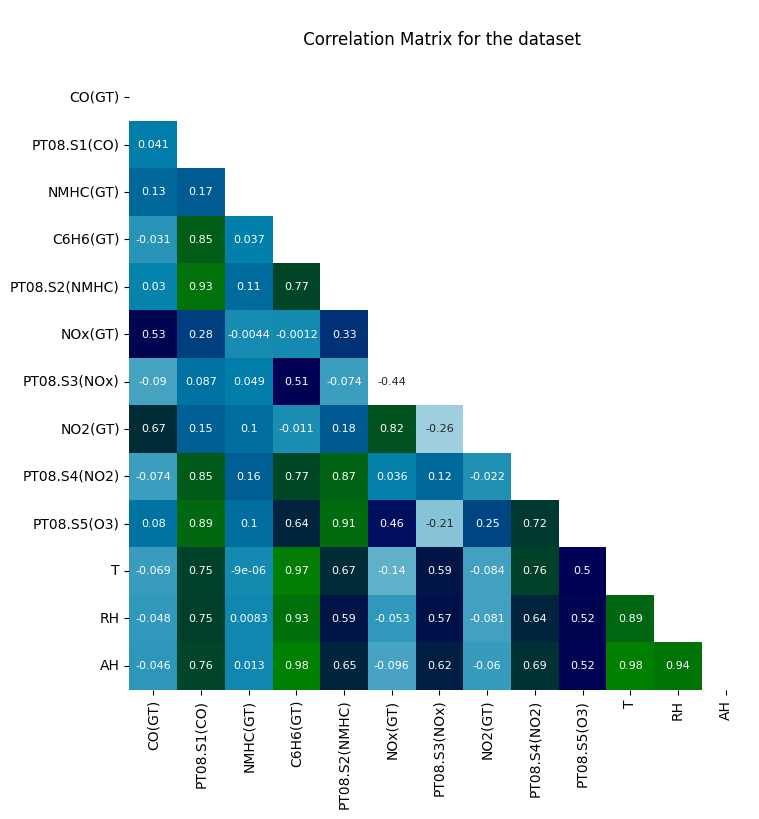

In [92]:
corr = data_p_object.data.corr()
mask = np.ones_like(corr,dtype=np.bool_)
mask[np.tril_indices_from(mask)]=False
mask[np.diag_indices_from(mask)]=True
fig,axes = plt.subplots(nrows=1,ncols=1,figsize=(8,8))
sns.heatmap(corr,annot=True,mask=mask,ax=axes,annot_kws={'fontsize':8},cbar=False,cmap='ocean_r')
axes.set_title('\n Correlation Matrix for the dataset\n')
fig.show()

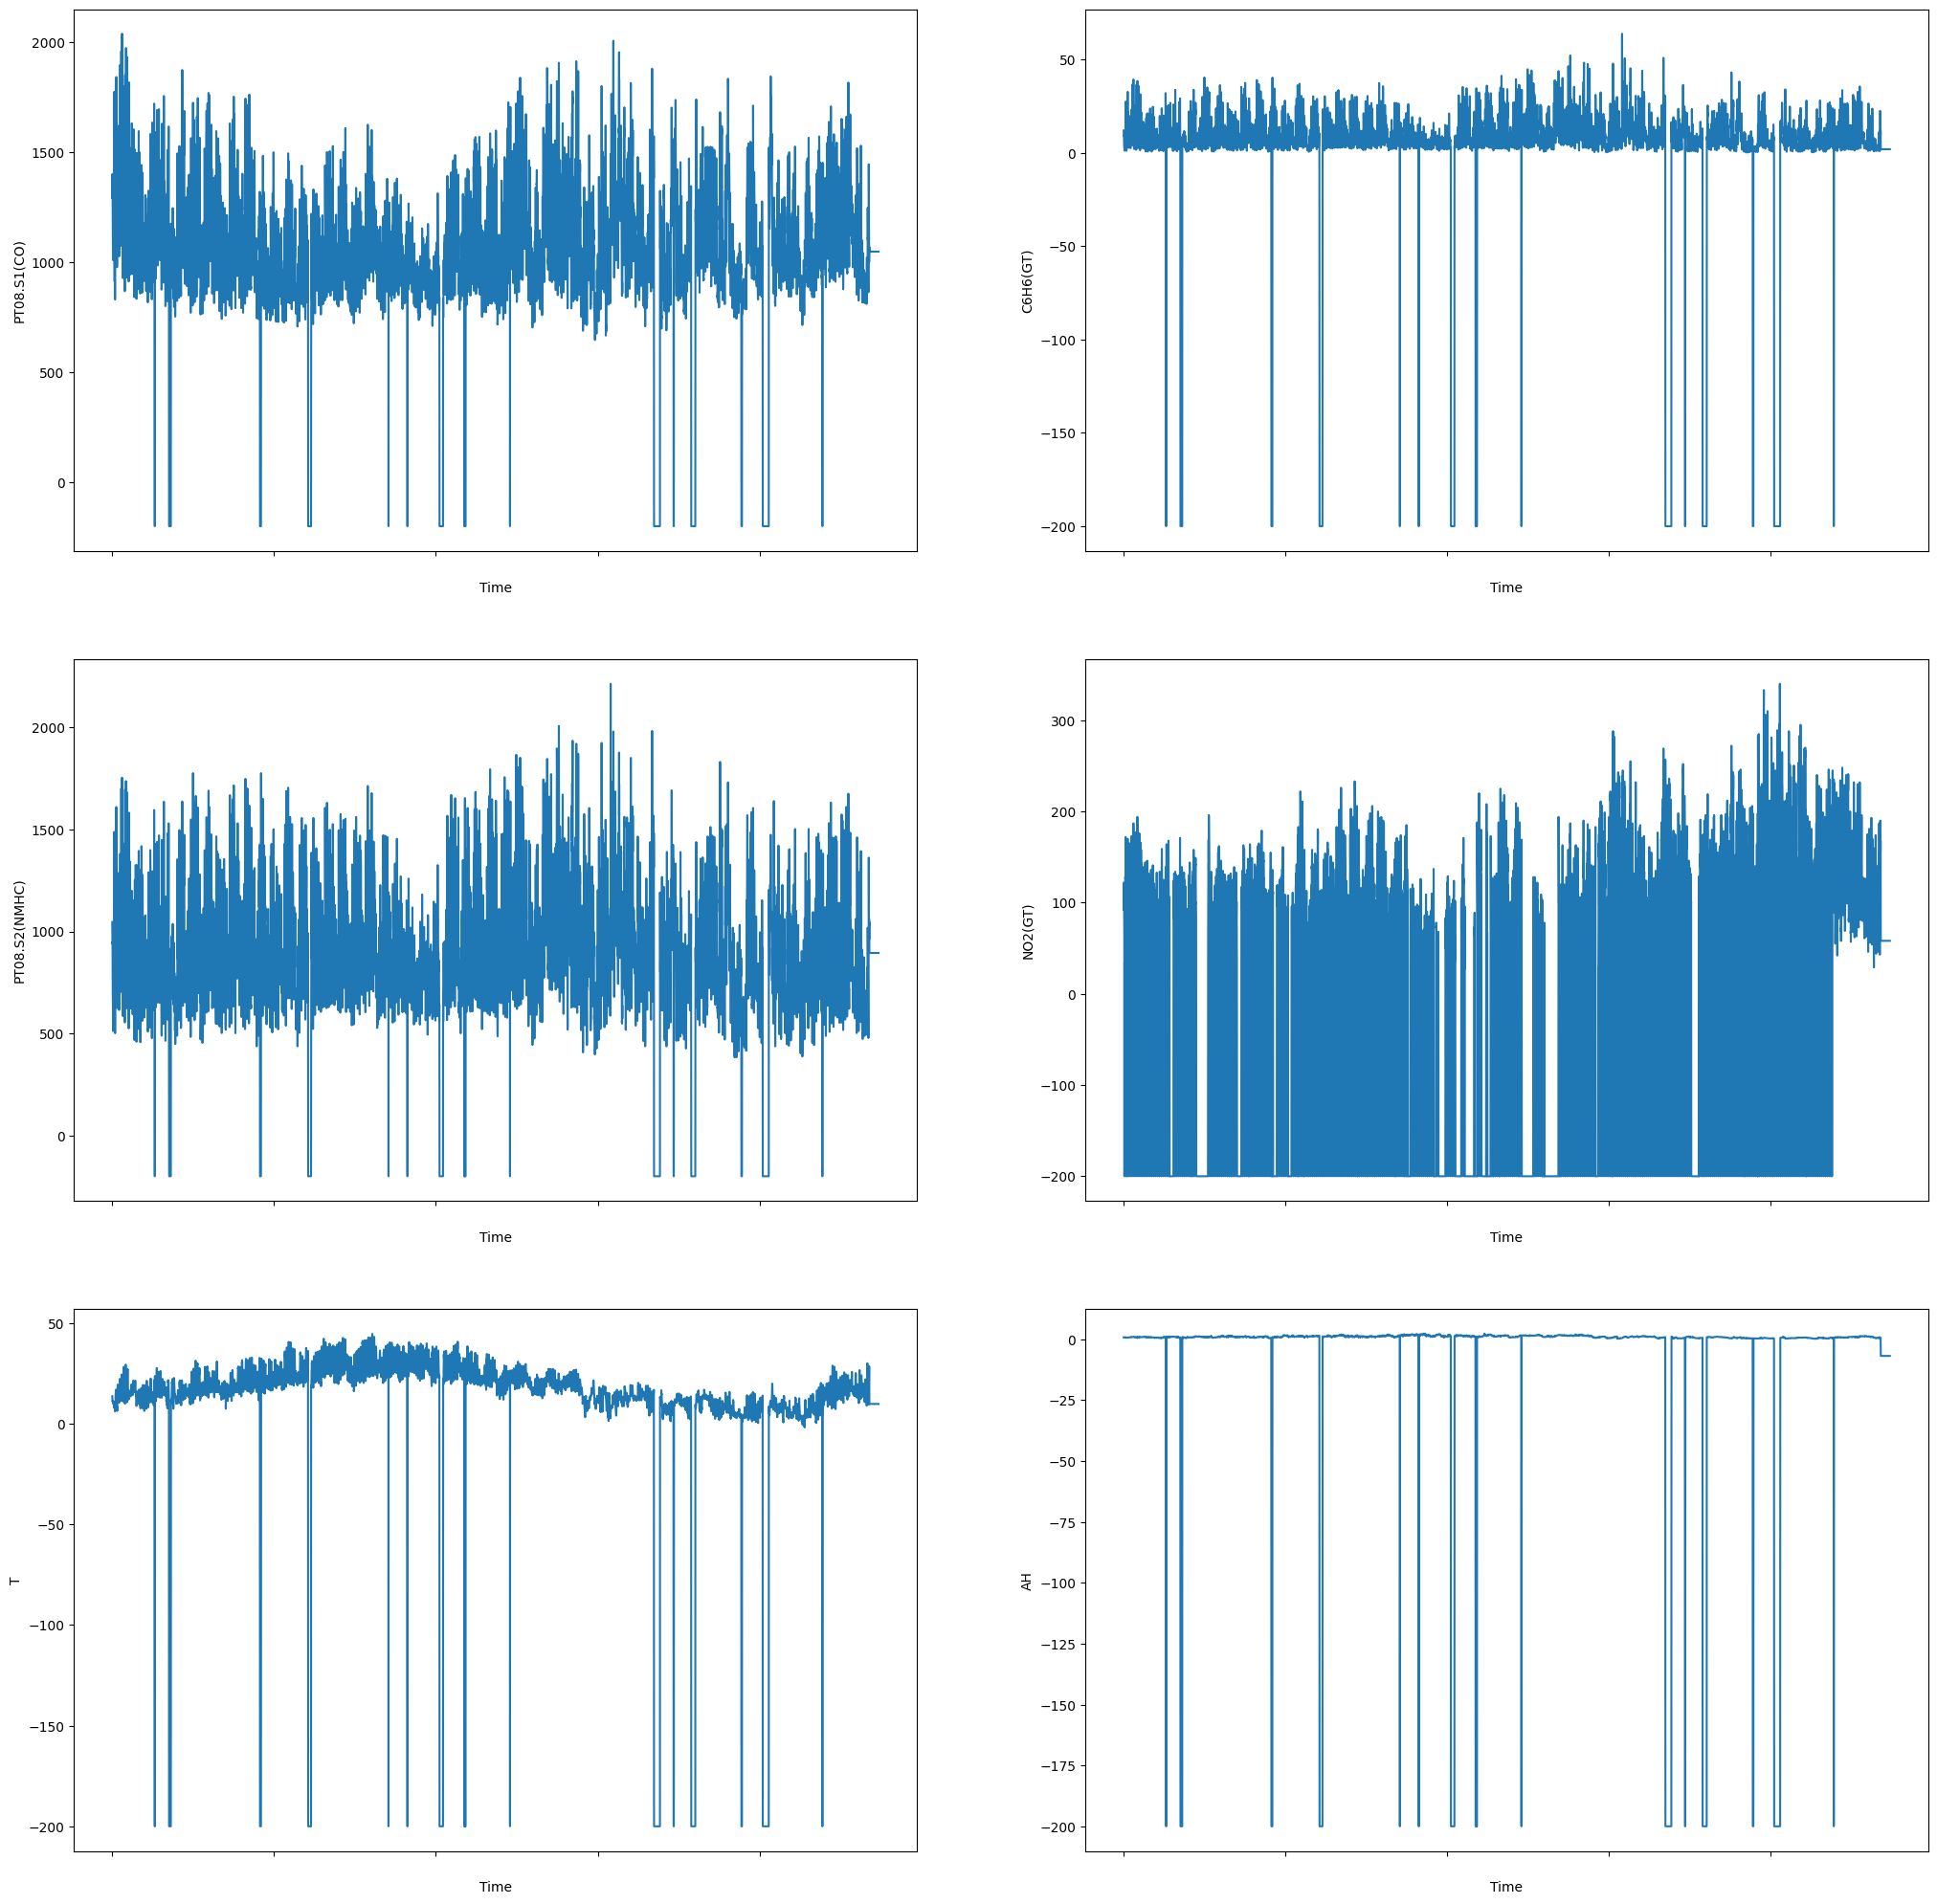

In [93]:
fig,axes = plt.subplots(nrows=3,ncols=2,figsize=(25,25))
row=column=0
for col in ['PT08.S1(CO)','C6H6(GT)', 'PT08.S2(NMHC)','NO2(GT)','T', 'AH']:
     if column not in [2,4]:
        axes[row][column].plot(data_p_object.data[col])
        axes[row][column].set_xticklabels([])
        axes[row][column].set_xlabel('\nTime')
        axes[row][column].set_ylabel(col)
        column+=1
     else:
        column=0
        row+=1
        axes[row][column].plot(data_p_object.data[col])
        axes[row][column].set_xticklabels([])
        axes[row][column].set_xlabel('\nTime')
        axes[row][column].set_ylabel(col)
        column+=1
fig.show()

#### DATA PREPROCESSING

##### INITIALIZING THE TARGET AND FEATURES

In [94]:
data_p_object.out_in('RH')

##### SPLITTING THE DATASET INTO TRAINING AND TESTING

In [95]:
data_p_object.split(0.2,rs=42)
print(data_p_object.train_features.shape)
print(data_p_object.test_features.shape)
print(data_p_object.val_features.shape)

(7576, 12)
(1705, 12)
(190, 12)


##### NORMALIZING THE DATASET

In [96]:
data_p_object.standardize_or_normalize('Normalize')

#### MODEL FORMULATION

##### INITIALIZING THE CLASS OBJECT

In [97]:
model_obj = MachineLearningRegression(data_p_object)
review = model_obj.evaluvate()

##### FITTING THE MODEL AND EVALUVATING

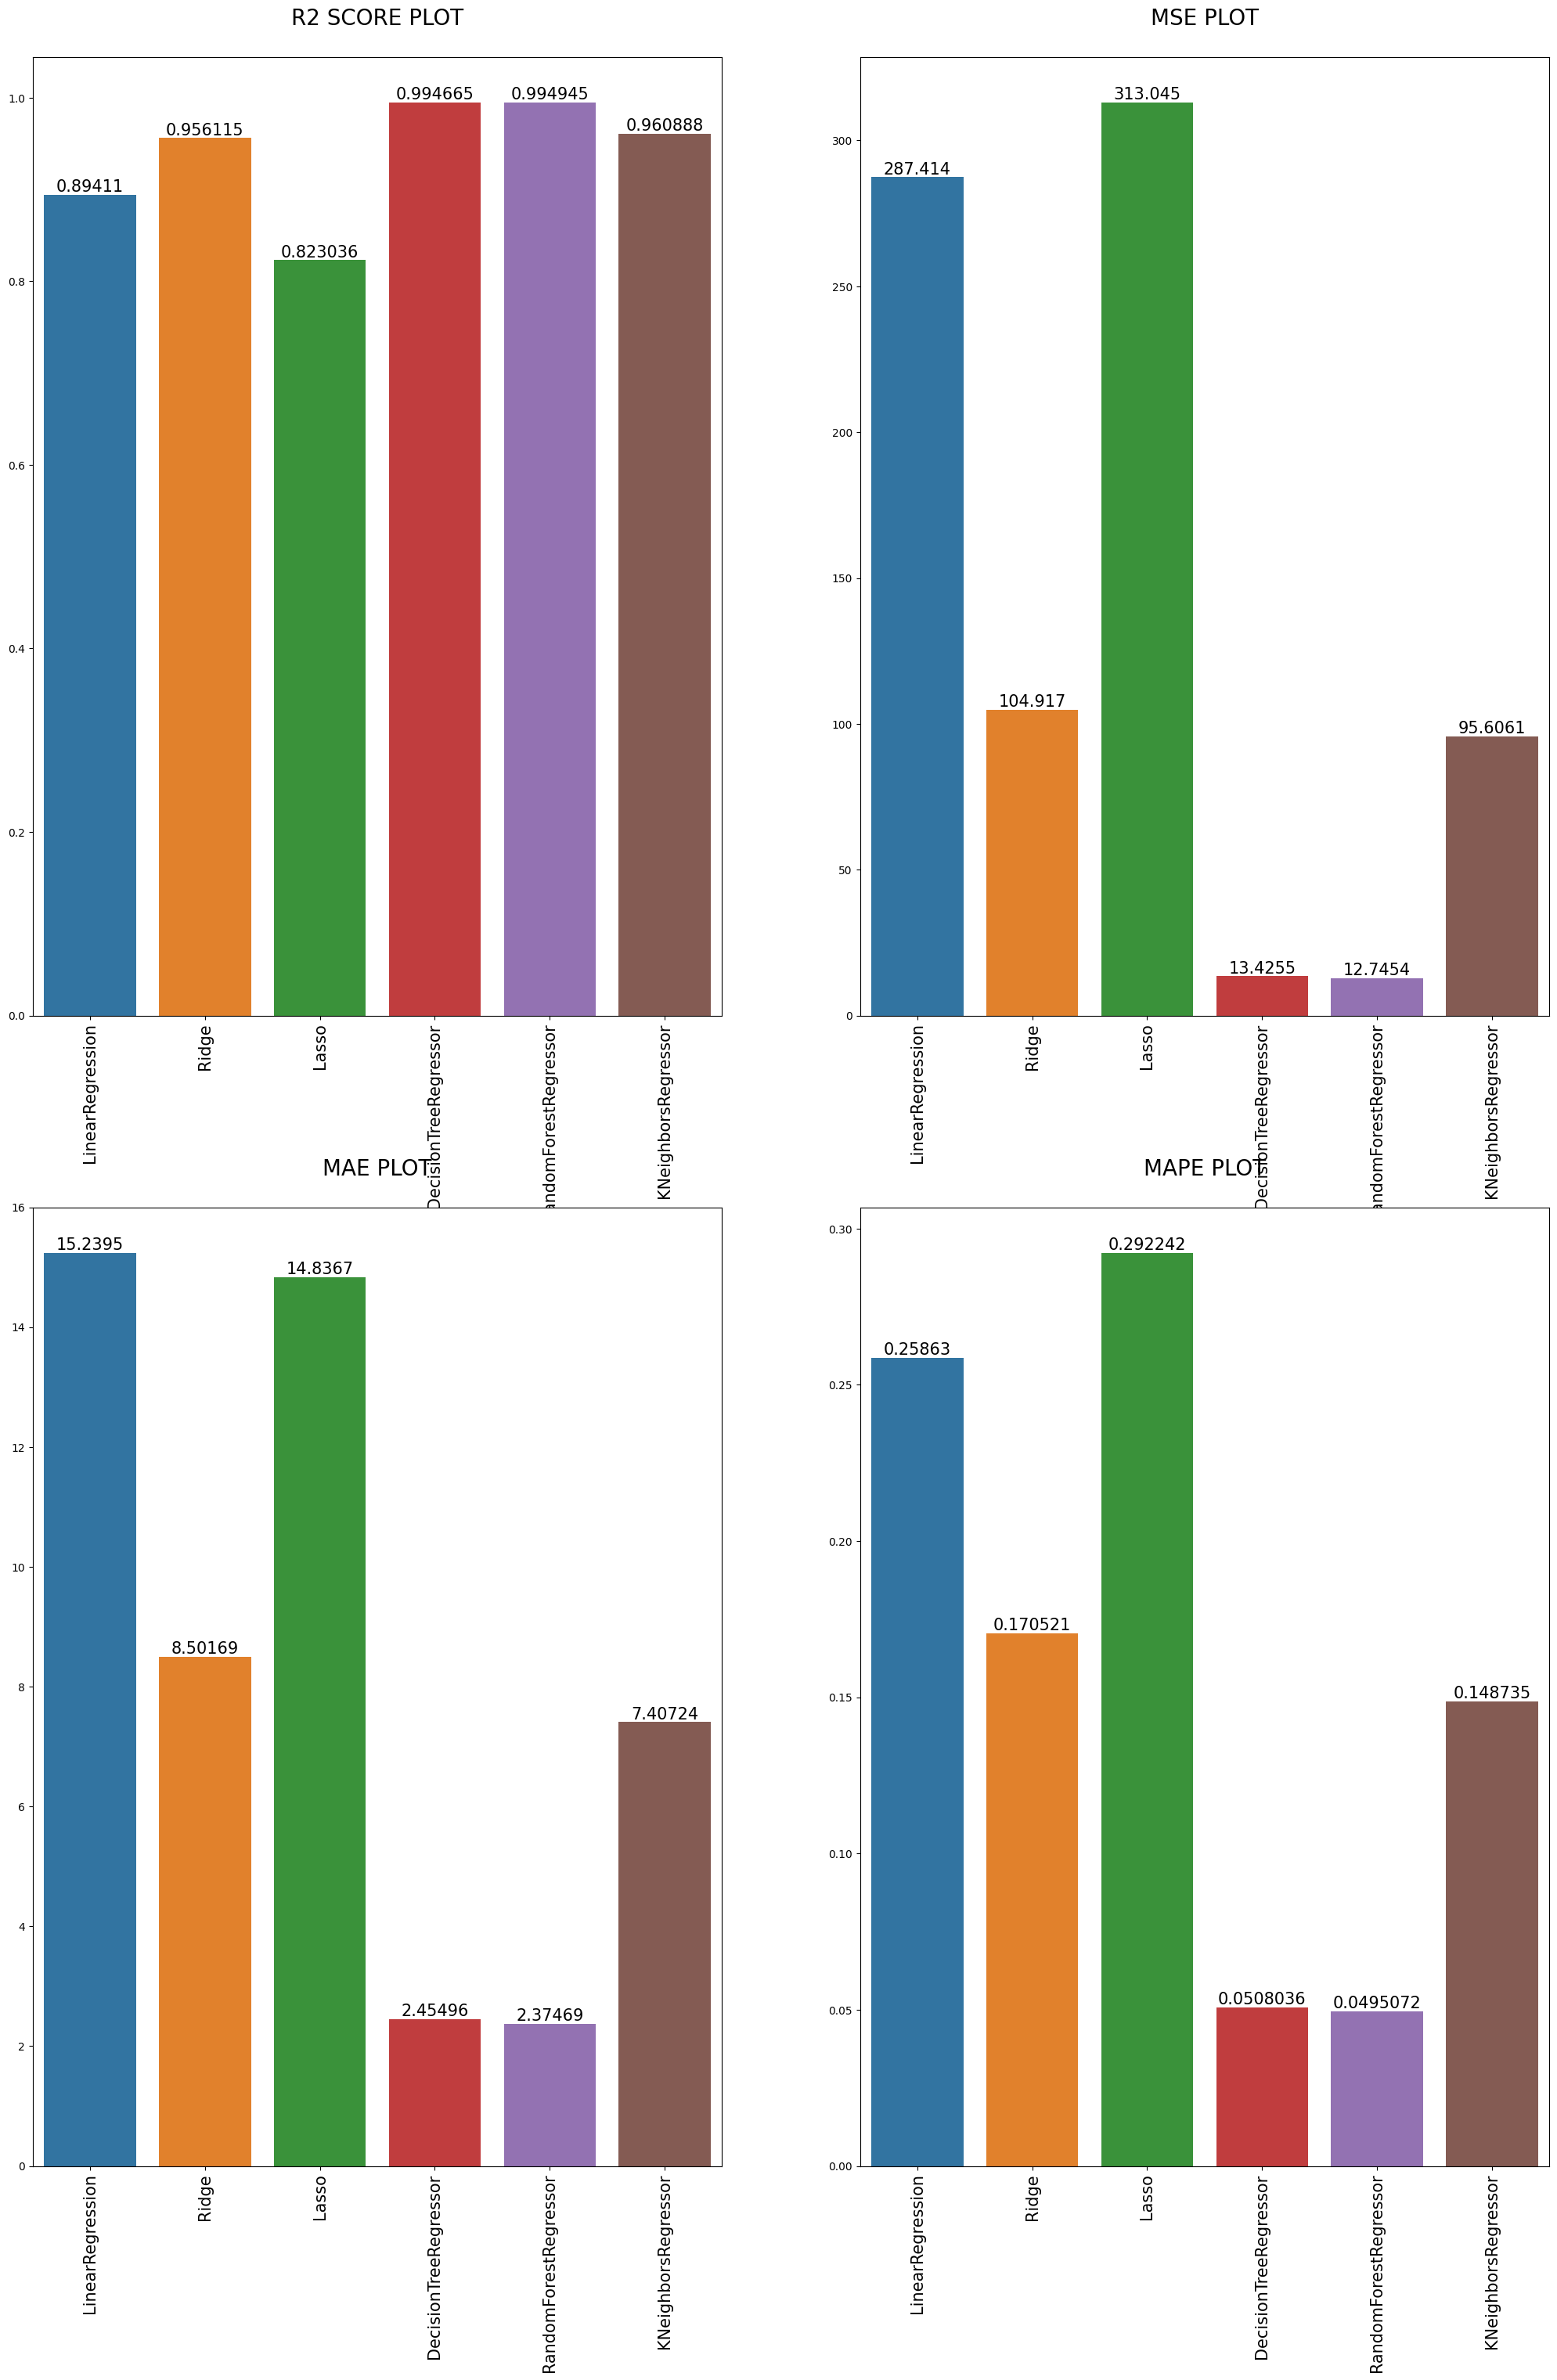

In [105]:
r2_score_list,MSE_list,MAE_list,MAPE_list={},{},{},{}
for model in review:
    if model!='best model':
        r2_score_list[model] = review[model]['r2 score']
        MSE_list[model] = review[model]['MSE']
        MAE_list[model] = review[model]['MAE']
        MAPE_list[model] = review[model]['MAPE']
fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(25,35))
# Figure 
a = sns.barplot(x=list(r2_score_list.keys()),y=list(r2_score_list.values()),ax=axes[0][0])
a.set_title("R2 SCORE PLOT\n",fontsize=20)
a.set_xticklabels(a.get_xticklabels(),rotation=90,fontsize=15)
for size in a.containers:
    a.bar_label(size,fontsize=15)

# Figure 
b = sns.barplot(x=list(MSE_list.keys()),y=list(MSE_list.values()),ax=axes[0][1])
b.set_title("MSE PLOT\n",fontsize=20)
b.set_xticklabels(a.get_xticklabels(),rotation=90,fontsize=15)
for size in b.containers:
    b.bar_label(size,fontsize=15)

# Figure 
c = sns.barplot(x=list(MAE_list.keys()),y=list(MAE_list.values()),ax=axes[1][0])
c.set_title("MAE PLOT\n",fontsize=20)
c.set_xticklabels(a.get_xticklabels(),rotation=90,fontsize=15)
for size in c.containers:
    c.bar_label(size,fontsize=15)

# Figure 
d = sns.barplot(x=list(MAPE_list.keys()),y=list(MAPE_list.values()),ax=axes[1][1])
d.set_title("MAPE PLOT\n",fontsize=20)
d.set_xticklabels(a.get_xticklabels(),rotation=90,fontsize=15)
for size in d.containers:
    d.bar_label(size,fontsize=15)
fig.show()

#### Applying K Fold to try to increase accuracy for linear regression and lasso

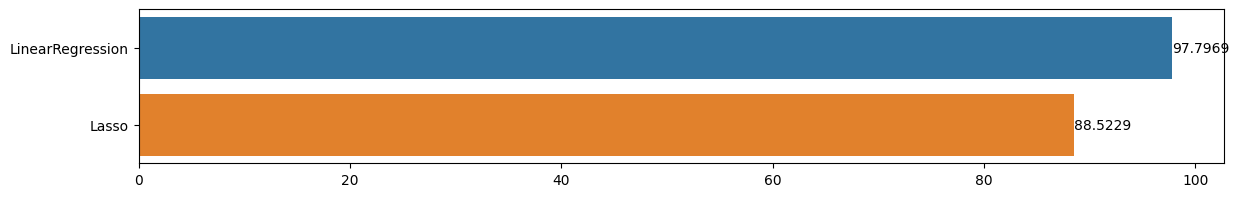

In [99]:
fig,axes = plt.subplots(figsize=(14,2))
kf = KFold(n_splits=10)
from sklearn.linear_model import LinearRegression,Lasso
models = [LinearRegression(),Lasso()]
score_list = {'LinearRegression':[],'Lasso':[]}
for model in models:
    for train,test in kf.split(data_p_object.train_features,data_p_object.train_target):
        model.fit(data_p_object.train_features.iloc[train],data_p_object.train_target.iloc[train])
        score_list[str(model).replace("()","")].append(model.score(data_p_object.train_features.iloc[train],data_p_object.train_target.iloc[train]))
    score_list[str(model).replace("()","")] = max(score_list[str(model).replace("()","")])*100
a = sns.barplot(y = list(score_list.keys()),x = list(score_list.values()),ax=axes)
for i in a.containers:
    a.bar_label(i)
fig.show()

##### Fitting on the validation set and plotting the accuracy

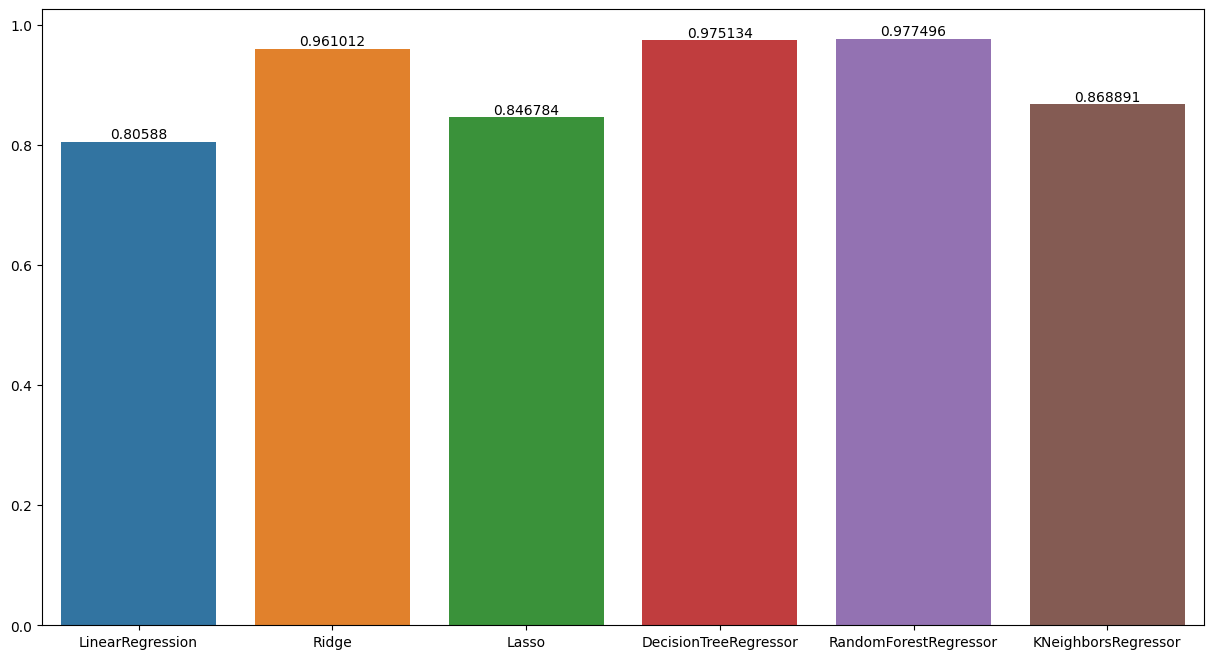

In [103]:
score_list={}
for i in model_obj.trained_models:
    score_list[str(i).replace("()","")] = i.score(data_p_object.val_features,data_p_object.val_target)
fig,axes = plt.subplots(figsize=(15,8))
a = sns.barplot(x = list(score_list.keys()),y = list(score_list.values()),ax=axes)
for i in a.containers:
    a.bar_label(i)

#### Getting the best K by comparing acurracy v/s K

The best value of K is 10


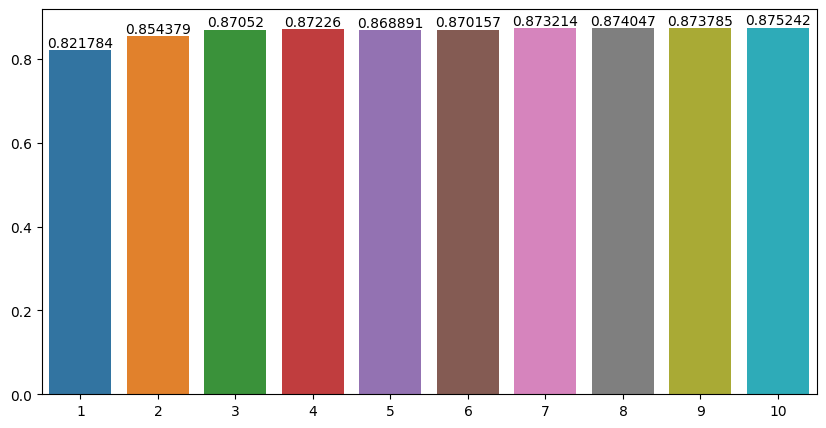

In [104]:
from sklearn.neighbors import KNeighborsRegressor
model_list = {str(i):KNeighborsRegressor(i) for i in range(1,11)}
accuracy_list={}
for model_name,model in model_list.items():
    model.fit(data_p_object.train_features,data_p_object.train_target)
    accuracy_list[model_name] = model.score(data_p_object.val_features,data_p_object.val_target)
fig,axes = plt.subplots(figsize=(10,5))
a = sns.barplot(x=list(accuracy_list.keys()),y=list(accuracy_list.values()),ax=axes)
for i in a.containers:
    a.bar_label(i)
print("The best value of K is",list(accuracy_list.keys())[list(accuracy_list.values()).index(max(list(accuracy_list.values())))])

## Dataset 2

### Breast cancer dataset from kaggle

#### READING THE DATASET

In [42]:
dataset_2 = pd.read_csv("Datasets/Breast_Cancer_Dataset.csv")
dataset_2.drop("Unnamed: 32",axis=1,inplace=True)

In [116]:
dataset_2['diagnosis'].value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

#### DATA ANALYSIS

In [43]:
dataset_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [44]:
dataset_2.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [45]:
dataset_2.isna().any()

id                         False
diagnosis                  False
radius_mean                False
texture_mean               False
perimeter_mean             False
area_mean                  False
smoothness_mean            False
compactness_mean           False
concavity_mean             False
concave points_mean        False
symmetry_mean              False
fractal_dimension_mean     False
radius_se                  False
texture_se                 False
perimeter_se               False
area_se                    False
smoothness_se              False
compactness_se             False
concavity_se               False
concave points_se          False
symmetry_se                False
fractal_dimension_se       False
radius_worst               False
texture_worst              False
perimeter_worst            False
area_worst                 False
smoothness_worst           False
compactness_worst          False
concavity_worst            False
concave points_worst       False
symmetry_w

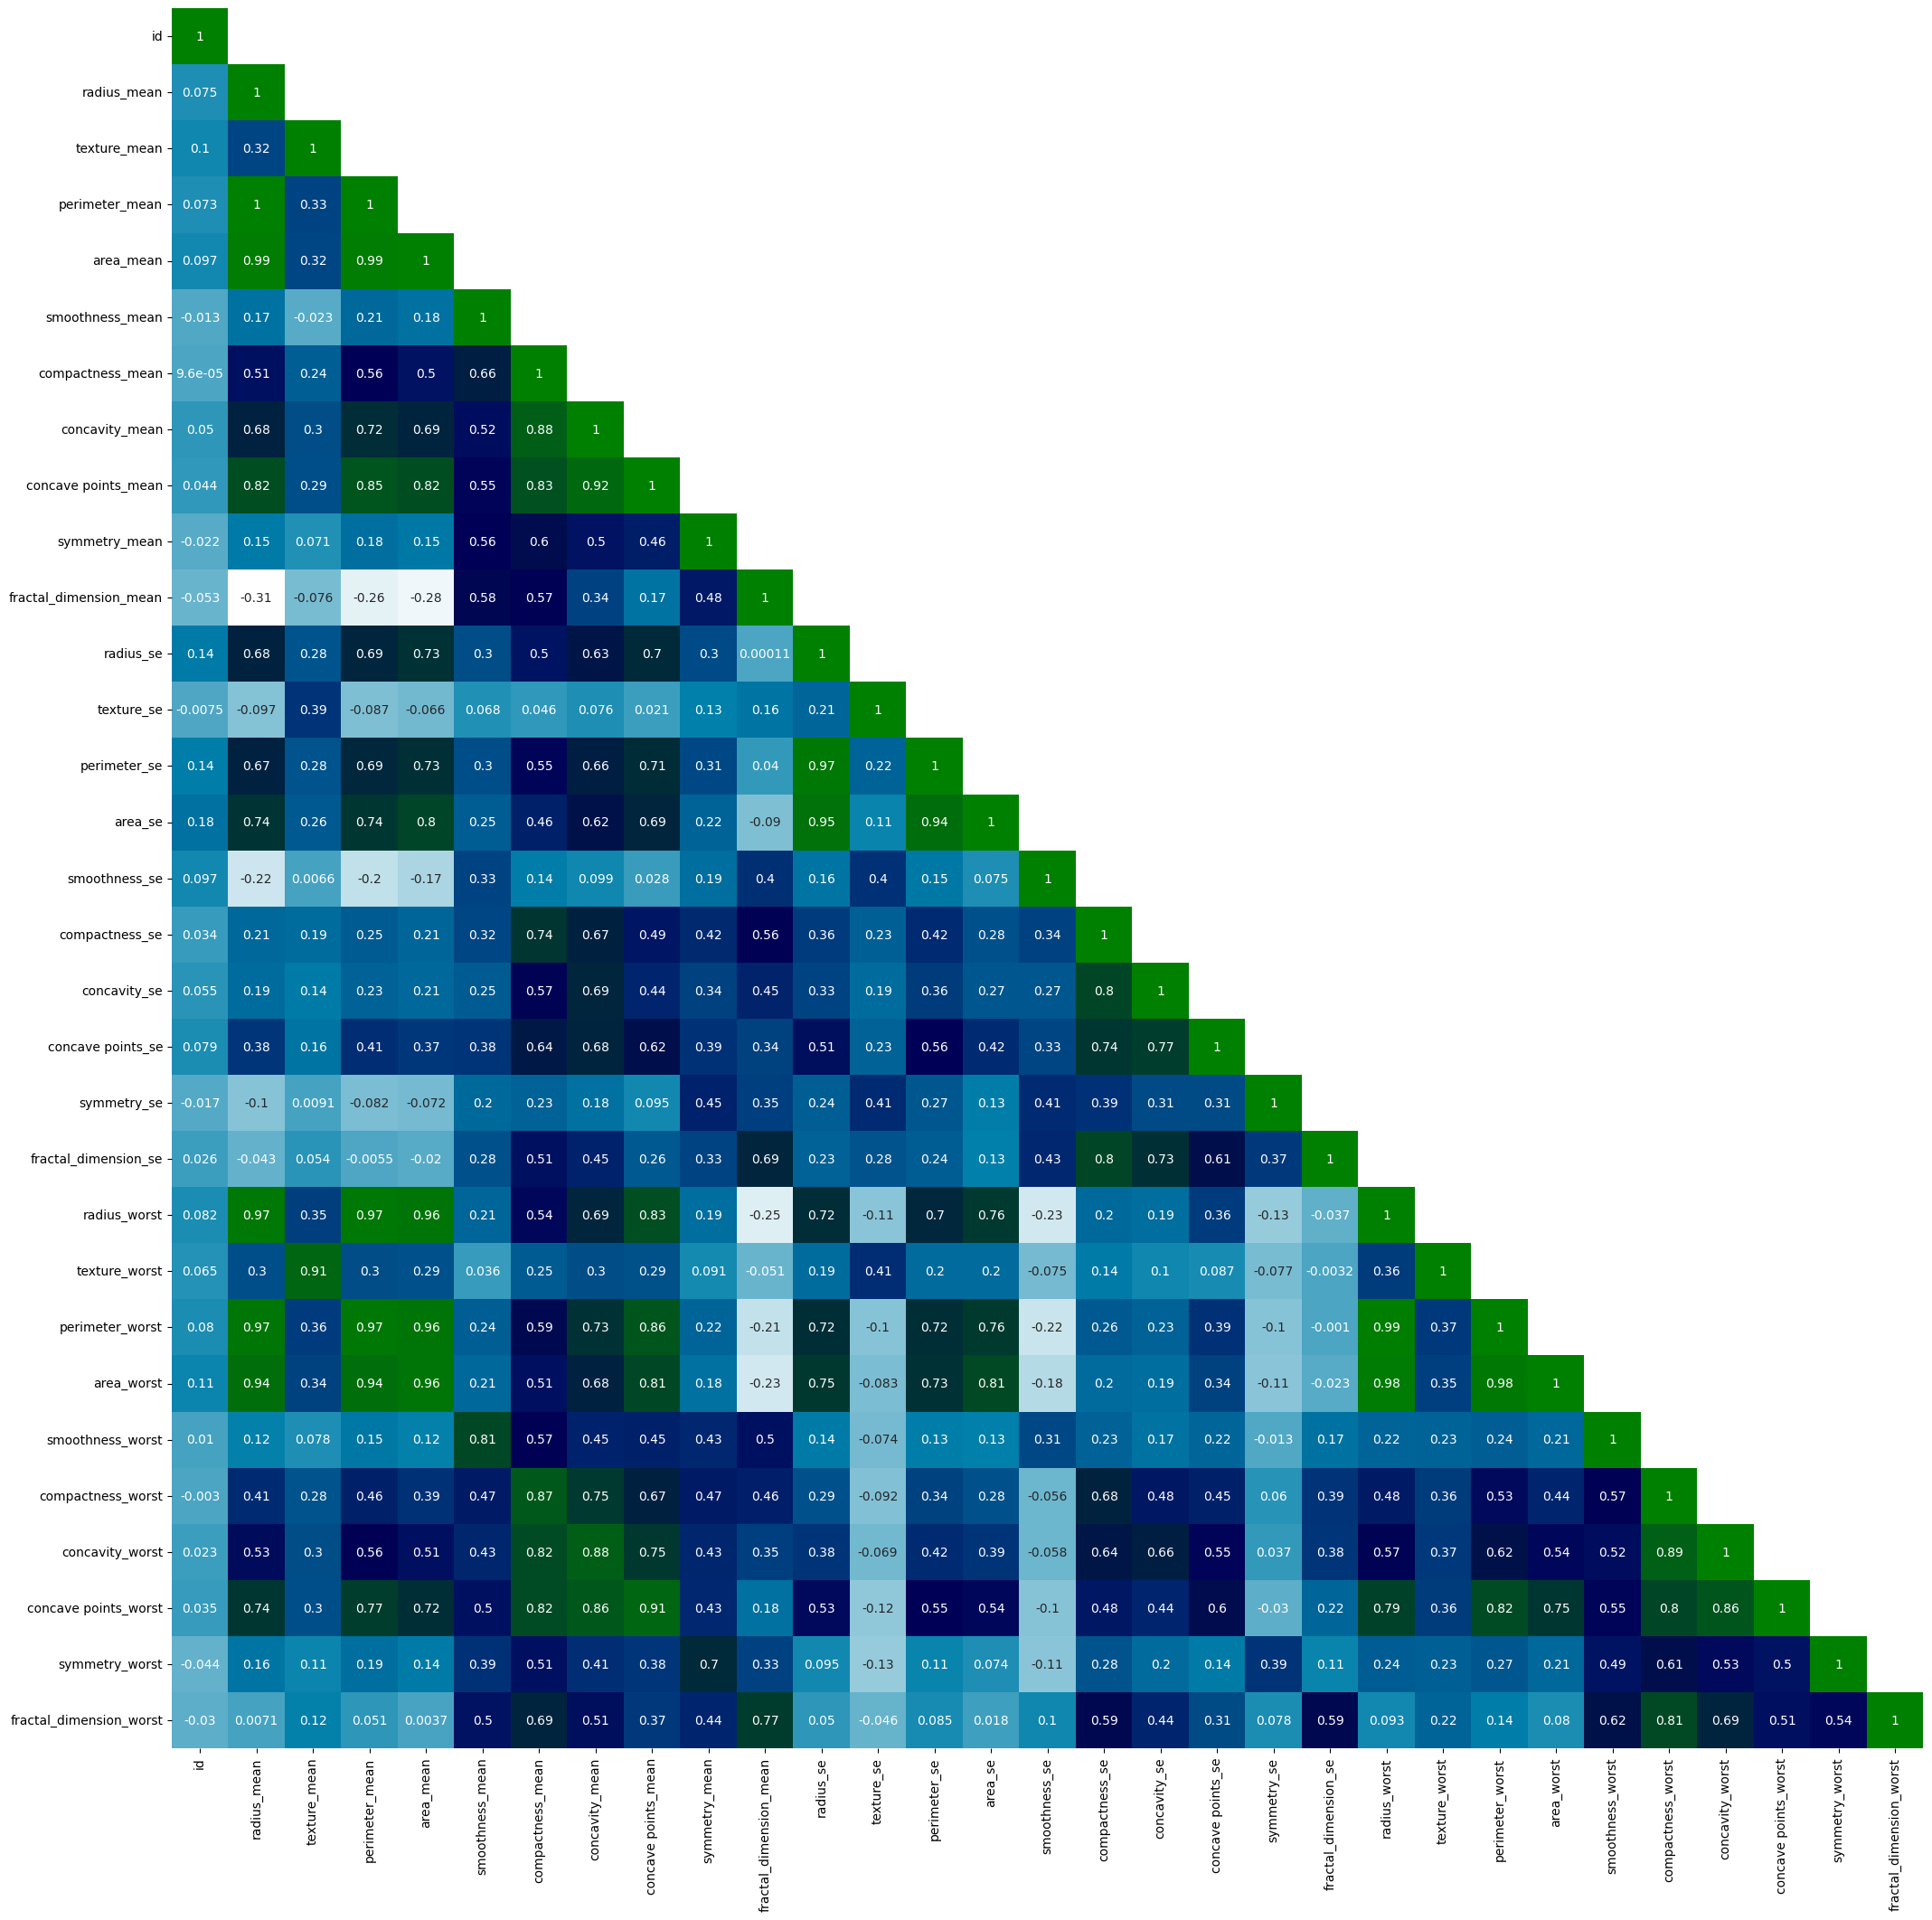

In [46]:
corr = dataset_2.corr()
mask = np.zeros_like(corr,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True
mask[np.diag_indices_from(mask)]=False
fig,axes = plt.subplots(nrows=1,ncols=1,figsize=(25,25))
a = sns.heatmap(corr,mask=mask,annot=True,cbar=False,cmap="ocean_r")

#### DATA PREPROCESSING

In [47]:
data_p_object_2 = DataPreprocessing(dataset_2)

##### Dropping unnecessay columns

In [48]:
data_p_object_2.drop_columns('id')

##### Encoding the categorical values

In [49]:
data_p_object_2.encode_categorical_columns()

##### Specifying the target and the features

In [50]:
data_p_object_2.out_in('diagnosis')

##### Splitting the dataset into train and test

In [52]:
data_p_object_2.split(0.3,0.1)
print(data_p_object_2.train_features.shape)
print(data_p_object_2.test_features.shape)
print(data_p_object_2.val_features.shape)

(398, 30)
(153, 30)
(18, 30)


##### Standardizing the dataset

In [157]:
data_p_object_2.standardize_or_normalize('Standard')

#### MODEL FORMULATION

In [111]:
model_2 = MacineLearningClassification(data_p_object_2)
review = model_2.evaluvate()

#### MODEL EVALUVATION

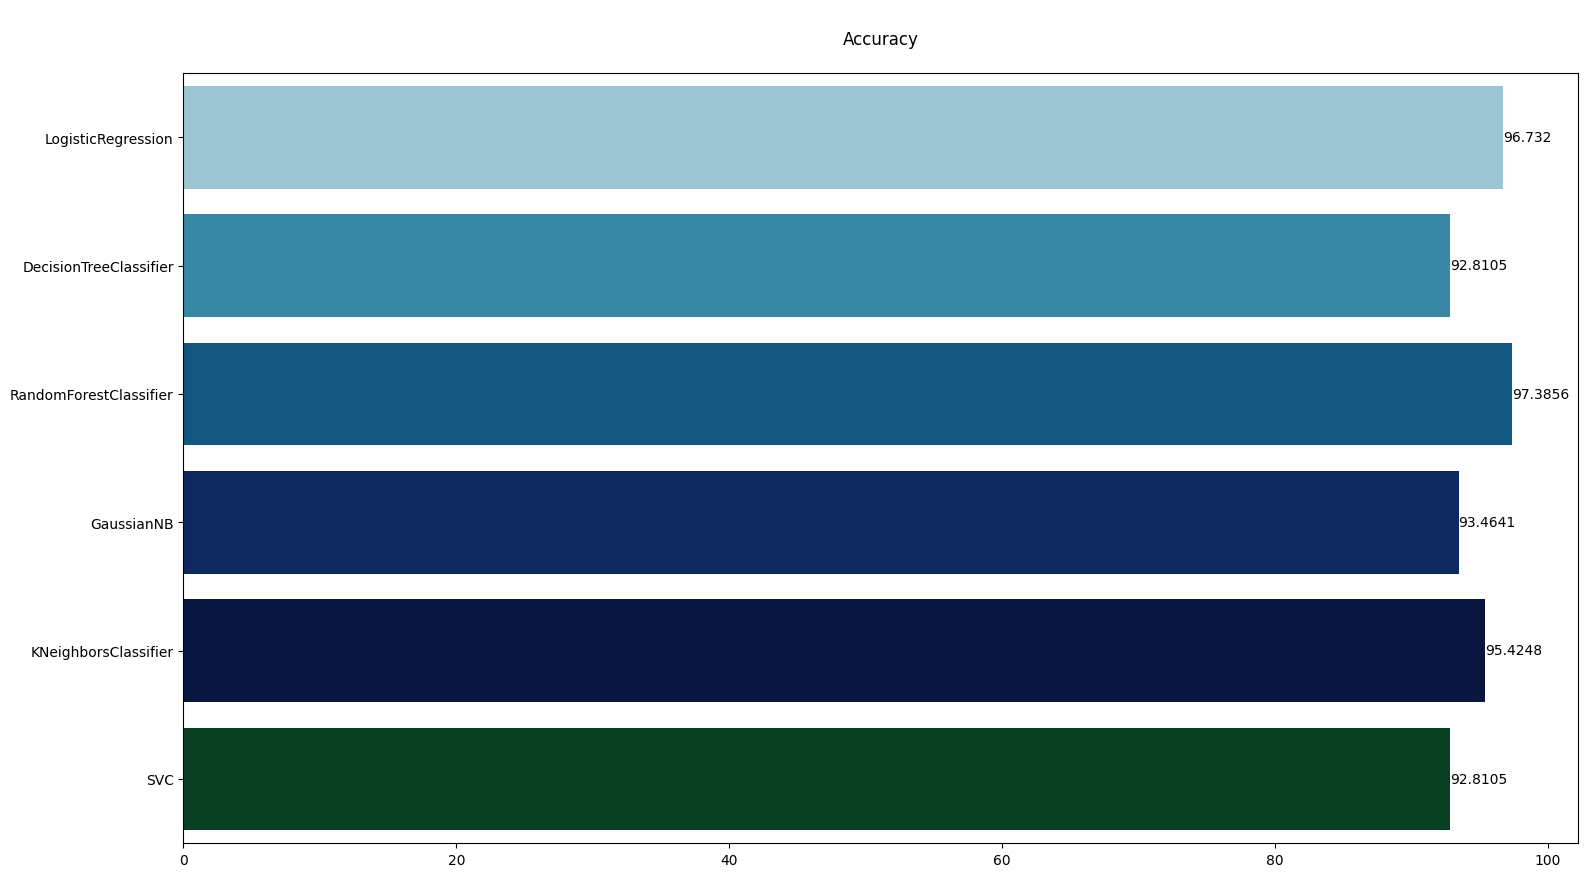

In [112]:
a = draw_plot(review,'score on test data')
a.set_title('\nAccuracy\n')
for s in a.containers:
    a.bar_label(s,fontsize=10)

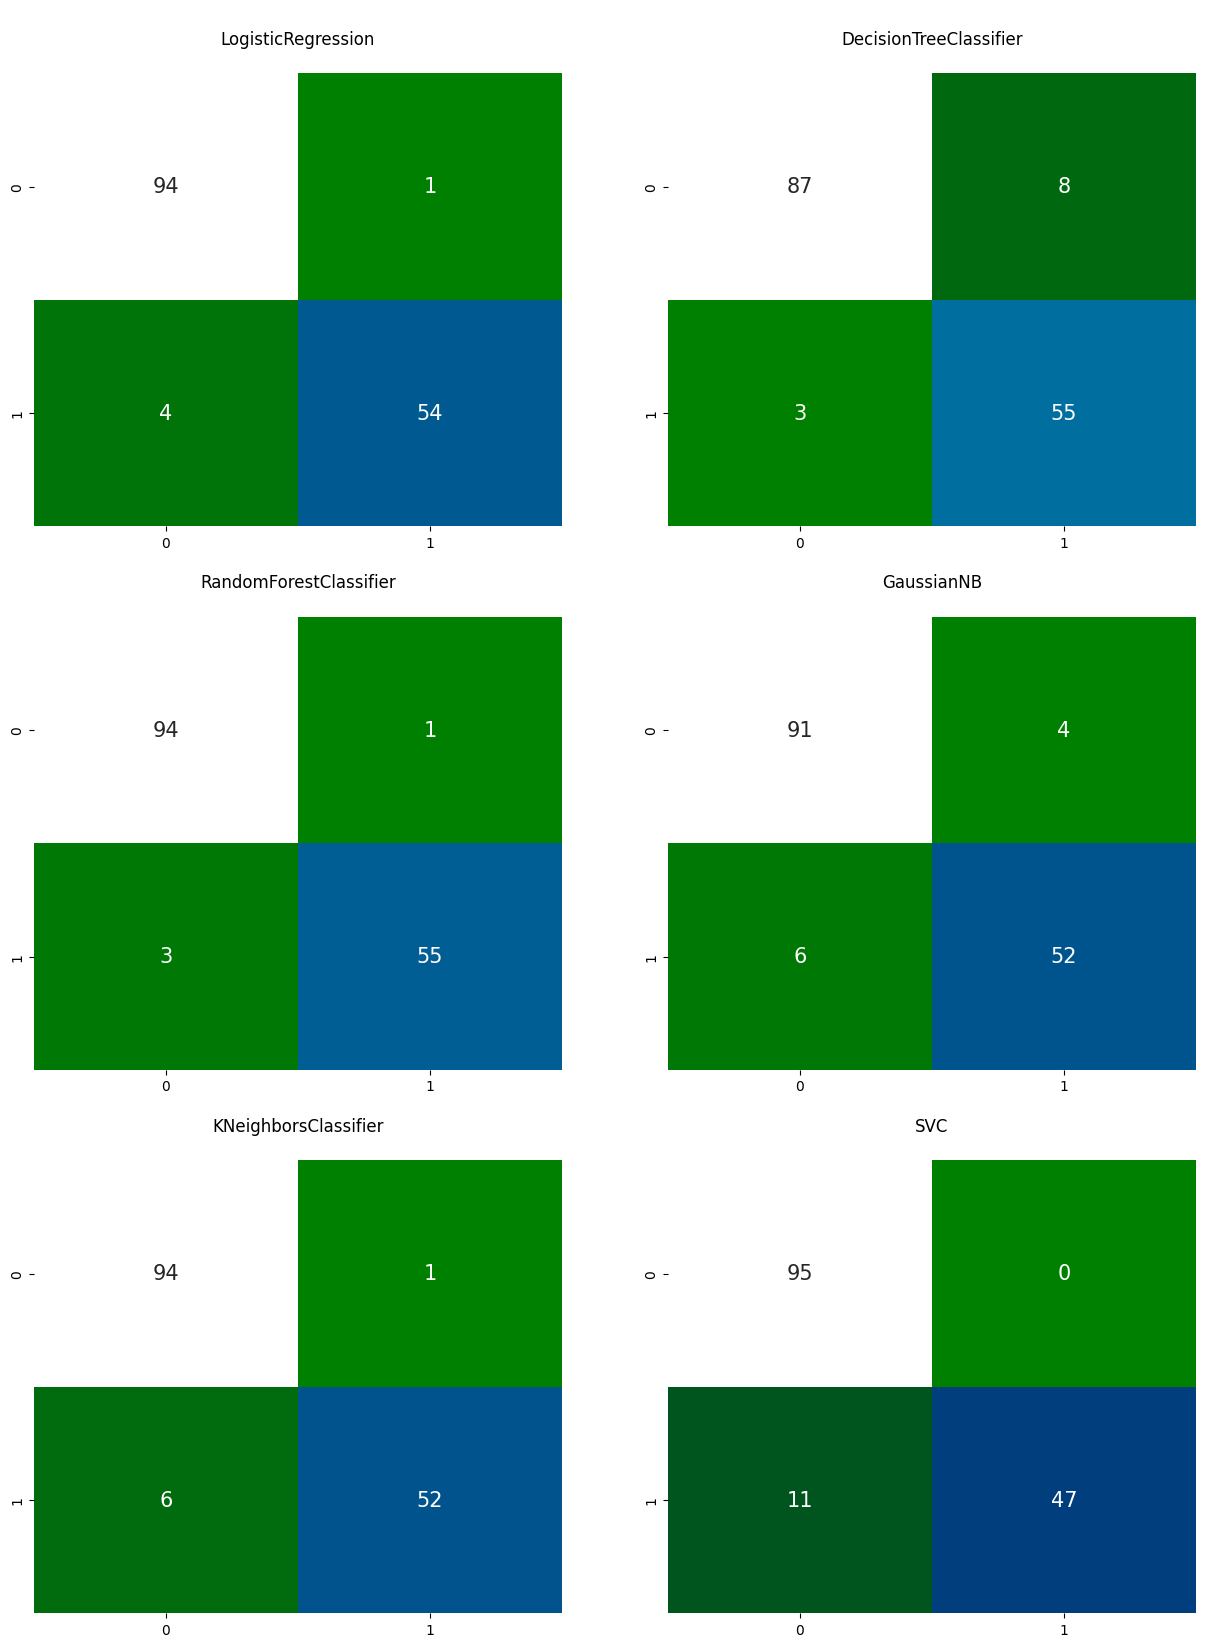

In [113]:
draw_heatmap(review)

##### Applying K Fold to increase the accuracy of Decision Tree classifier

In [114]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
model=DecisionTreeClassifier()
kf = KFold(n_splits=10)
a = cross_val_score(model,data_p_object_2.train_features,data_p_object_2.train_target,cv=kf)
print(list(a))
print("The maximum accuracy from decision tree classifier is",max(a)*100)

[0.9, 0.975, 0.925, 0.85, 0.925, 0.95, 0.875, 0.95, 0.8461538461538461, 0.9743589743589743]
The maximum accuracy from decision tree classifier is 97.5


##### Perfomance for validation set

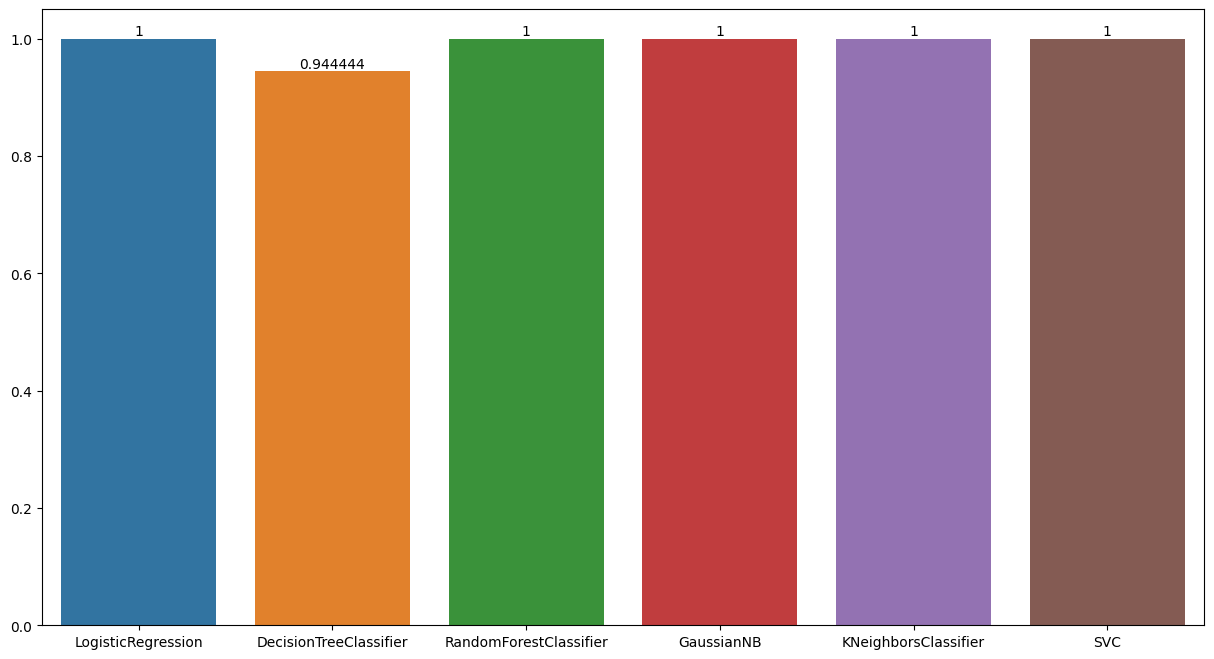

In [115]:
score_list={}
for i in model_2.trained_models:
    score_list[str(i).replace("()","")] = i.score(data_p_object_2.val_features,data_p_object_2.val_target)
fig,axes = plt.subplots(figsize=(15,8))
a = sns.barplot(x = list(score_list.keys()),y = list(score_list.values()),ax=axes)
for i in a.containers:
    a.bar_label(i)

##### Confusion matrix for validation set

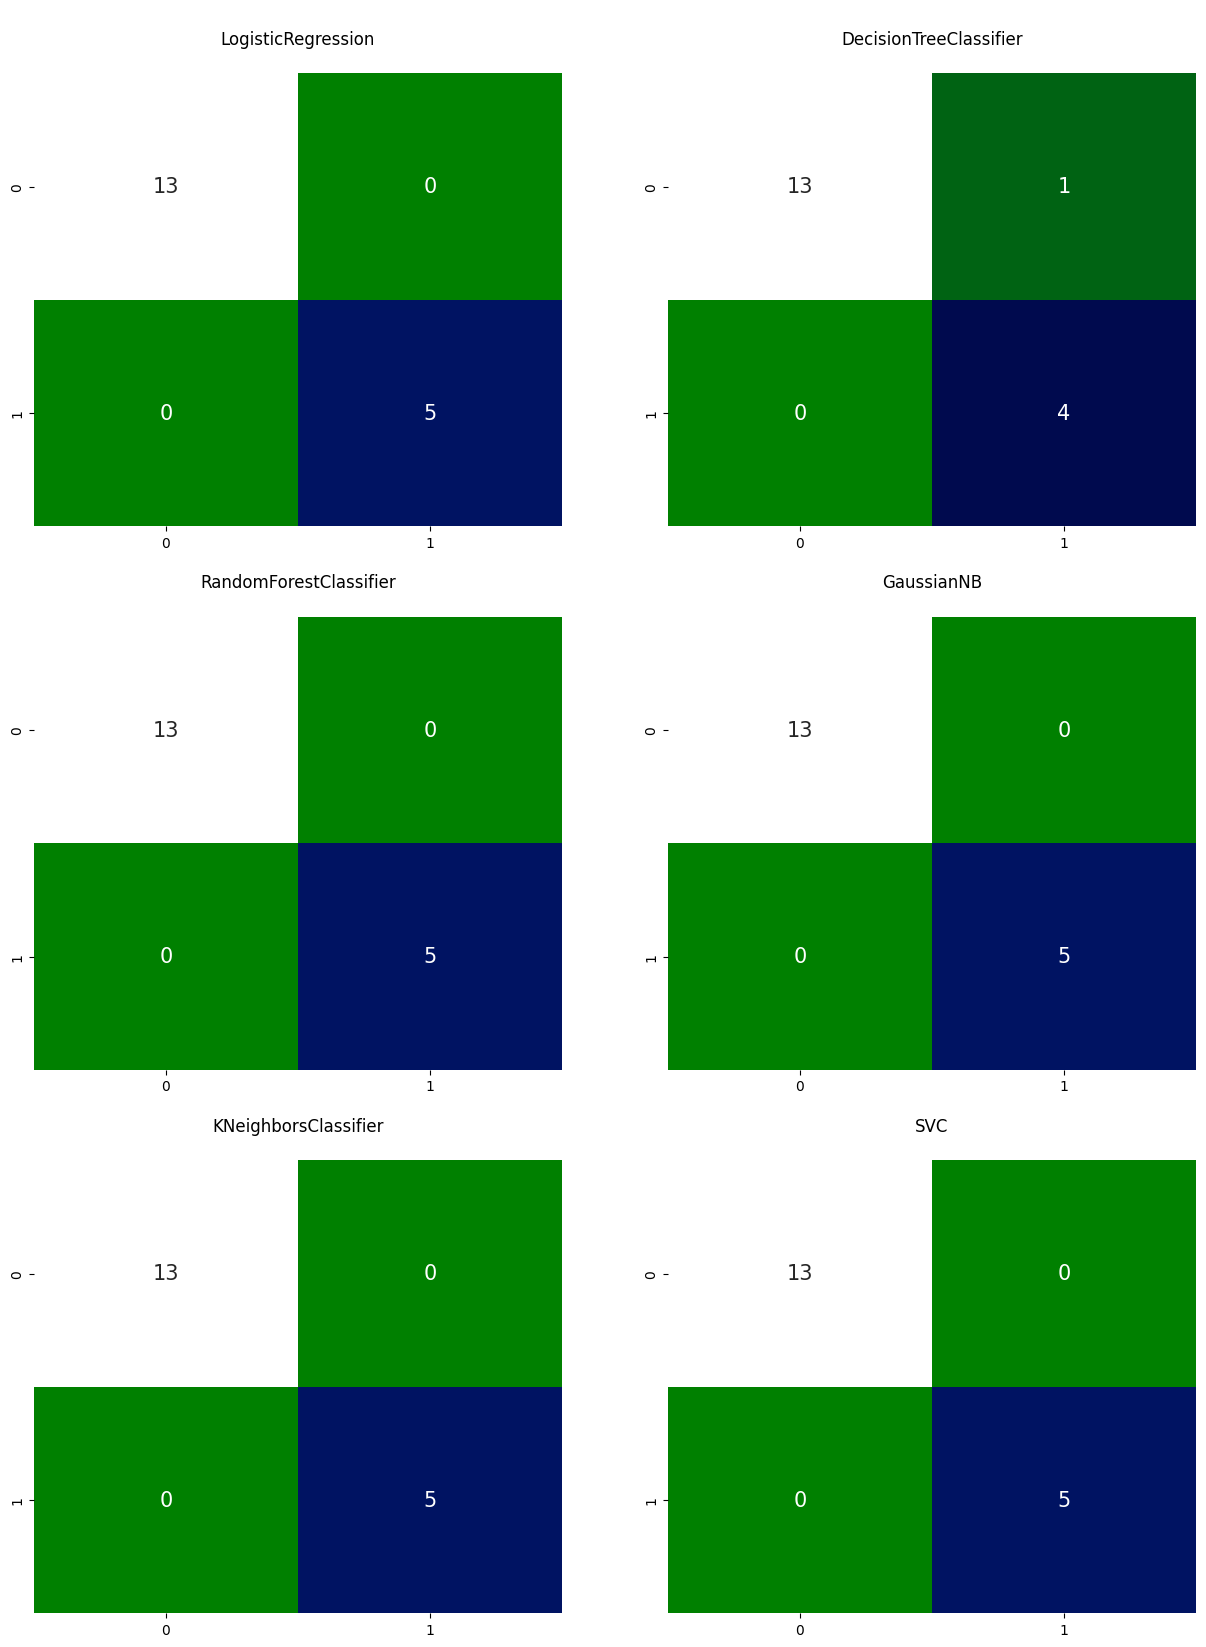

In [118]:
from sklearn.metrics import confusion_matrix
fig,axes = plt.subplots(nrows=3,ncols=2,figsize=(15,20))
confusion_matrixes ={str(model).replace("()",""):confusion_matrix(model.predict(data_p_object_2.val_features),data_p_object_2.val_target) for model in model_2.trained_models}
row = col = 0
for model in confusion_matrixes:
    if col in [2,4]:
        col=0
        row+=1
        a = sns.heatmap(confusion_matrixes[model],ax = axes[row][col],cmap='ocean',annot=True,cbar=False,annot_kws={'fontsize':15})
        a.set_title("\n"+model+"\n")
        col+=1
    else:
        a = sns.heatmap(confusion_matrixes[model],ax = axes[row][col],cmap='ocean',annot=True,cbar=False,annot_kws={'fontsize':15})
        col+=1
        a.set_title("\n"+model+"\n")
fig.show()     

## Dataset 3

### MNIST Dataset from sklearn

#### Importing and creating the dataset

In [53]:
from sklearn.datasets import load_digits
dataset_3 = pd.DataFrame(data = load_digits().data,columns = load_digits().feature_names)
dataset_3['label'] = load_digits().target

### DATA ANALYSIS

In [54]:
dataset_3.describe()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,label
count,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,...,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.0,0.303840,5.204786,11.835838,11.848080,5.781859,1.362270,0.129661,0.005565,1.993879,...,0.206455,0.000556,0.279354,5.557596,12.089037,11.809126,6.764051,2.067891,0.364496,4.490818
std,0.0,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383,0.094222,3.196160,...,0.984401,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122,2.865304
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,0.000000,0.000000,0.000000,2.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.000000,13.000000,14.000000,6.000000,0.000000,0.000000,4.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,10.000000,16.000000,16.000000,12.000000,2.000000,0.000000,7.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,15.000000,2.000000,16.000000,...,13.000000,1.000000,9.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,9.000000


In [55]:
dataset_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1797 entries, 0 to 1796
Data columns (total 65 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pixel_0_0  1797 non-null   float64
 1   pixel_0_1  1797 non-null   float64
 2   pixel_0_2  1797 non-null   float64
 3   pixel_0_3  1797 non-null   float64
 4   pixel_0_4  1797 non-null   float64
 5   pixel_0_5  1797 non-null   float64
 6   pixel_0_6  1797 non-null   float64
 7   pixel_0_7  1797 non-null   float64
 8   pixel_1_0  1797 non-null   float64
 9   pixel_1_1  1797 non-null   float64
 10  pixel_1_2  1797 non-null   float64
 11  pixel_1_3  1797 non-null   float64
 12  pixel_1_4  1797 non-null   float64
 13  pixel_1_5  1797 non-null   float64
 14  pixel_1_6  1797 non-null   float64
 15  pixel_1_7  1797 non-null   float64
 16  pixel_2_0  1797 non-null   float64
 17  pixel_2_1  1797 non-null   float64
 18  pixel_2_2  1797 non-null   float64
 19  pixel_2_3  1797 non-null   float64
 20  pixel_2_

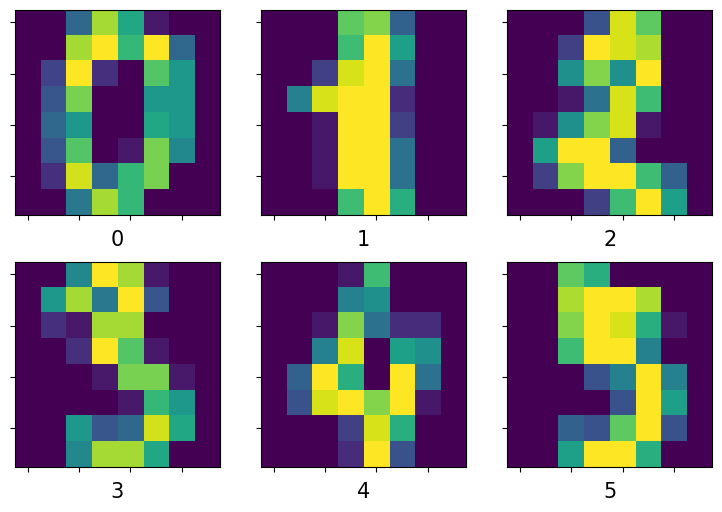

In [56]:
fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(9,6))
col =row=0
for i in range(6):
    if col == 3:
        col =0 
        row+=1
        axes[row][col].imshow(load_digits().images[i])
        axes[row][col].set_xlabel(dataset_3['label'].iloc[i],fontsize=15)
        axes[row][col].set_xticklabels([])
        axes[row][col].set_yticklabels([])
        col+=1
    else:
        axes[row][col].imshow(load_digits().images[i])
        axes[row][col].set_xlabel(dataset_3['label'].iloc[i],fontsize=15)
        axes[row][col].set_xticklabels([])
        axes[row][col].set_yticklabels([])
        col+=1
fig.show()
      

### DATA PREPROCESSING

In [57]:
data_p_object_3 = DataPreprocessing(dataset_3)

#### Specifying the input and output in the dataset

In [58]:
data_p_object_3.out_in('label')

#### Splitting the dataset into train and test

In [59]:
data_p_object_3.split(0.3)
print(data_p_object_3.train_features.shape)
print(data_p_object_3.test_features.shape)
print(data_p_object_3.val_features.shape)

(1257, 64)
(486, 64)
(54, 64)


#### Standardizing the data set 

In [170]:
data_p_object_3.standardize_or_normalize('standard')

### MODEL FORMULATION

In [121]:
model_3 = MacineLearningClassification(data_p_object_3)

In [122]:
review_object = model_3.evaluvate()

### MODEL EVALUVATION

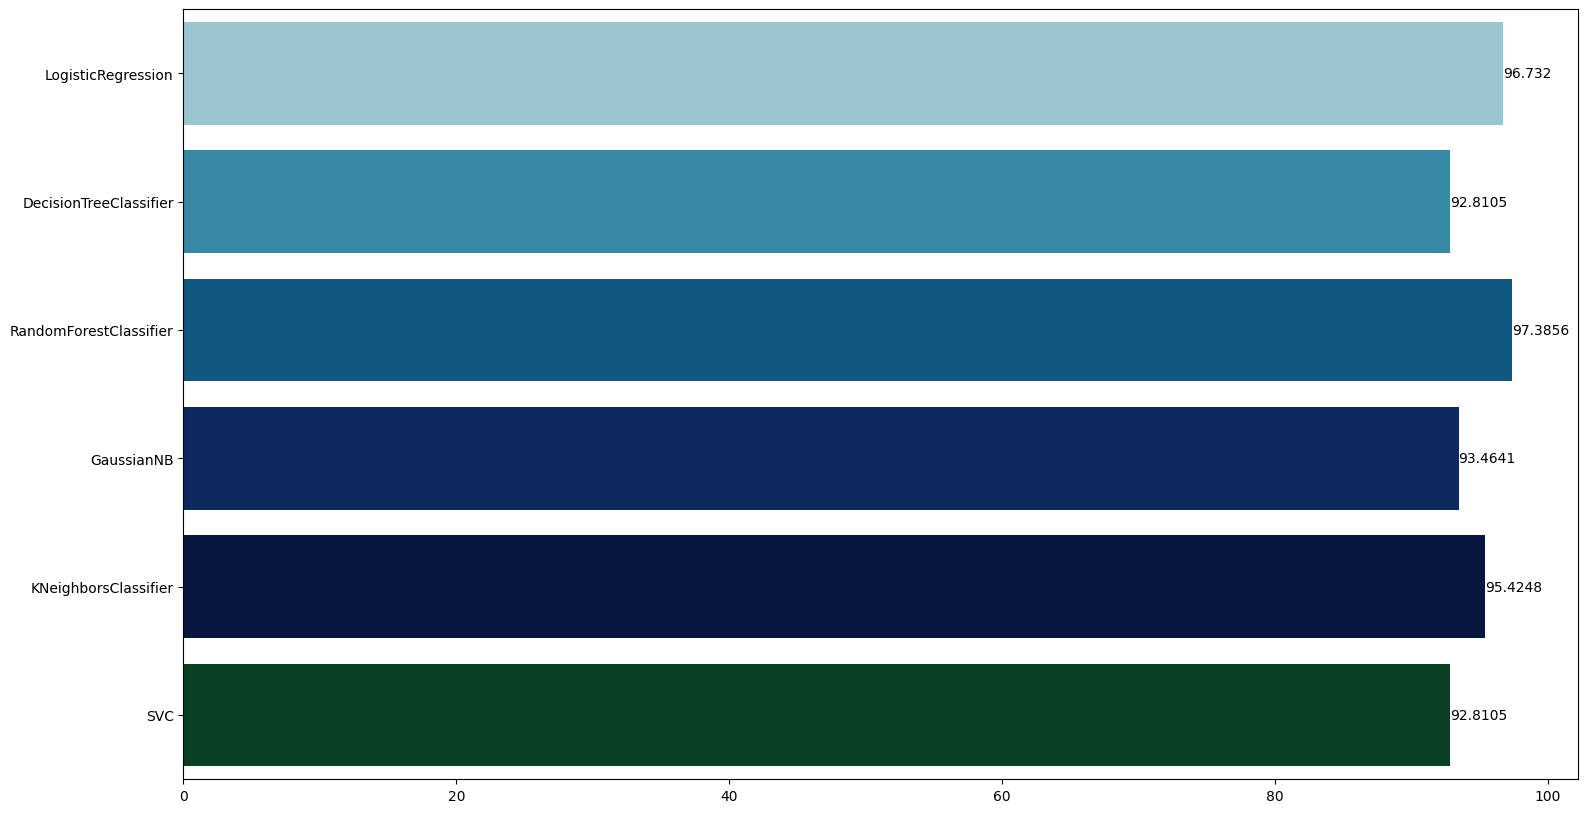

In [123]:
a_obj = draw_plot(review,'score on test data')
for i in a_obj.containers:
    a_obj.bar_label(i)

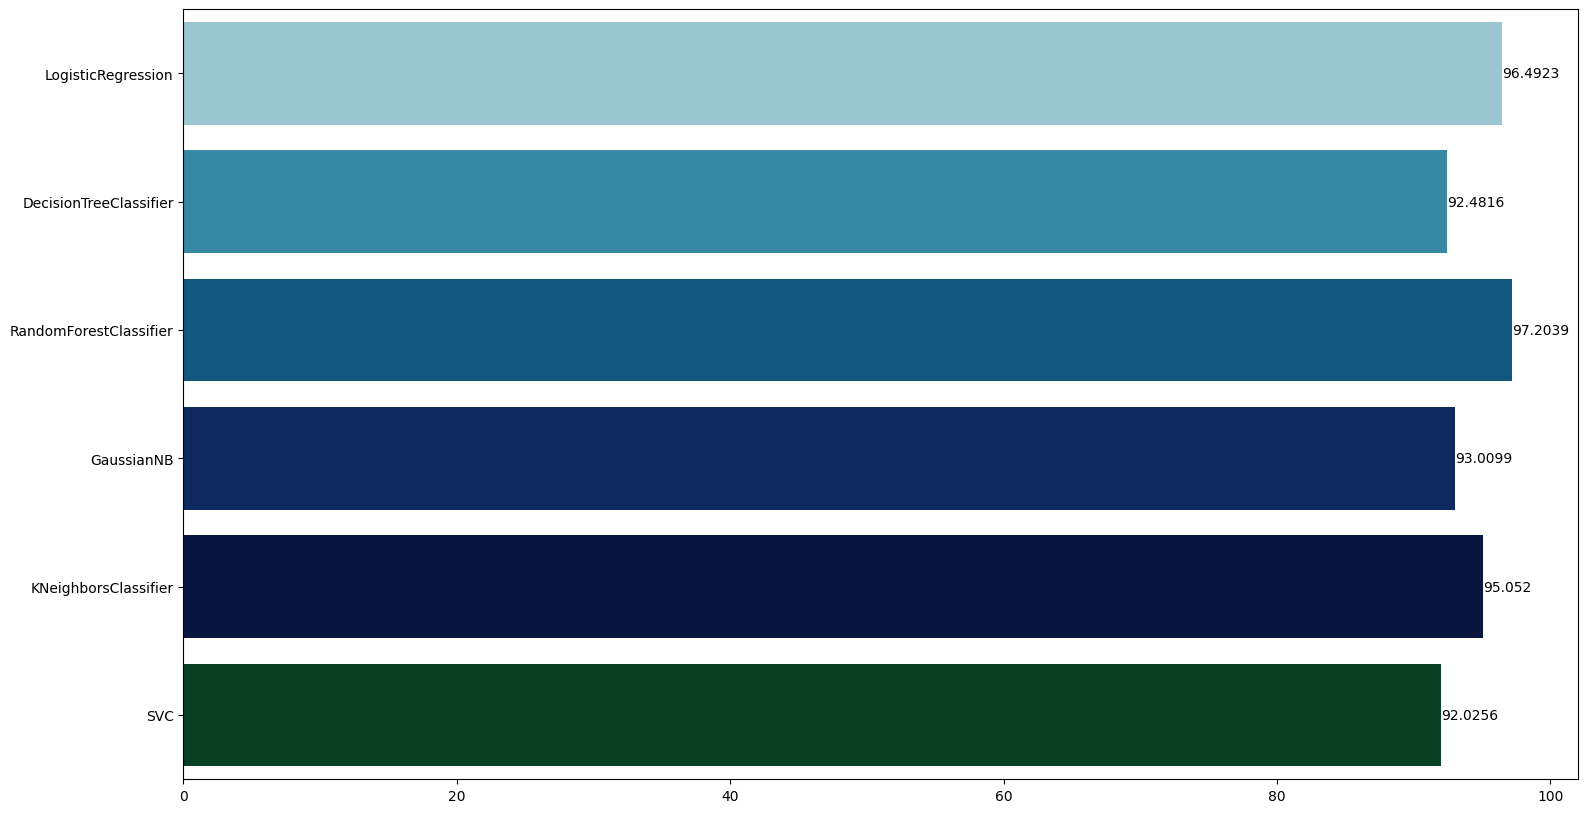

In [124]:
a_obj = draw_plot(review,'f1 score for test data')
for i in a_obj.containers:
    a_obj.bar_label(i)

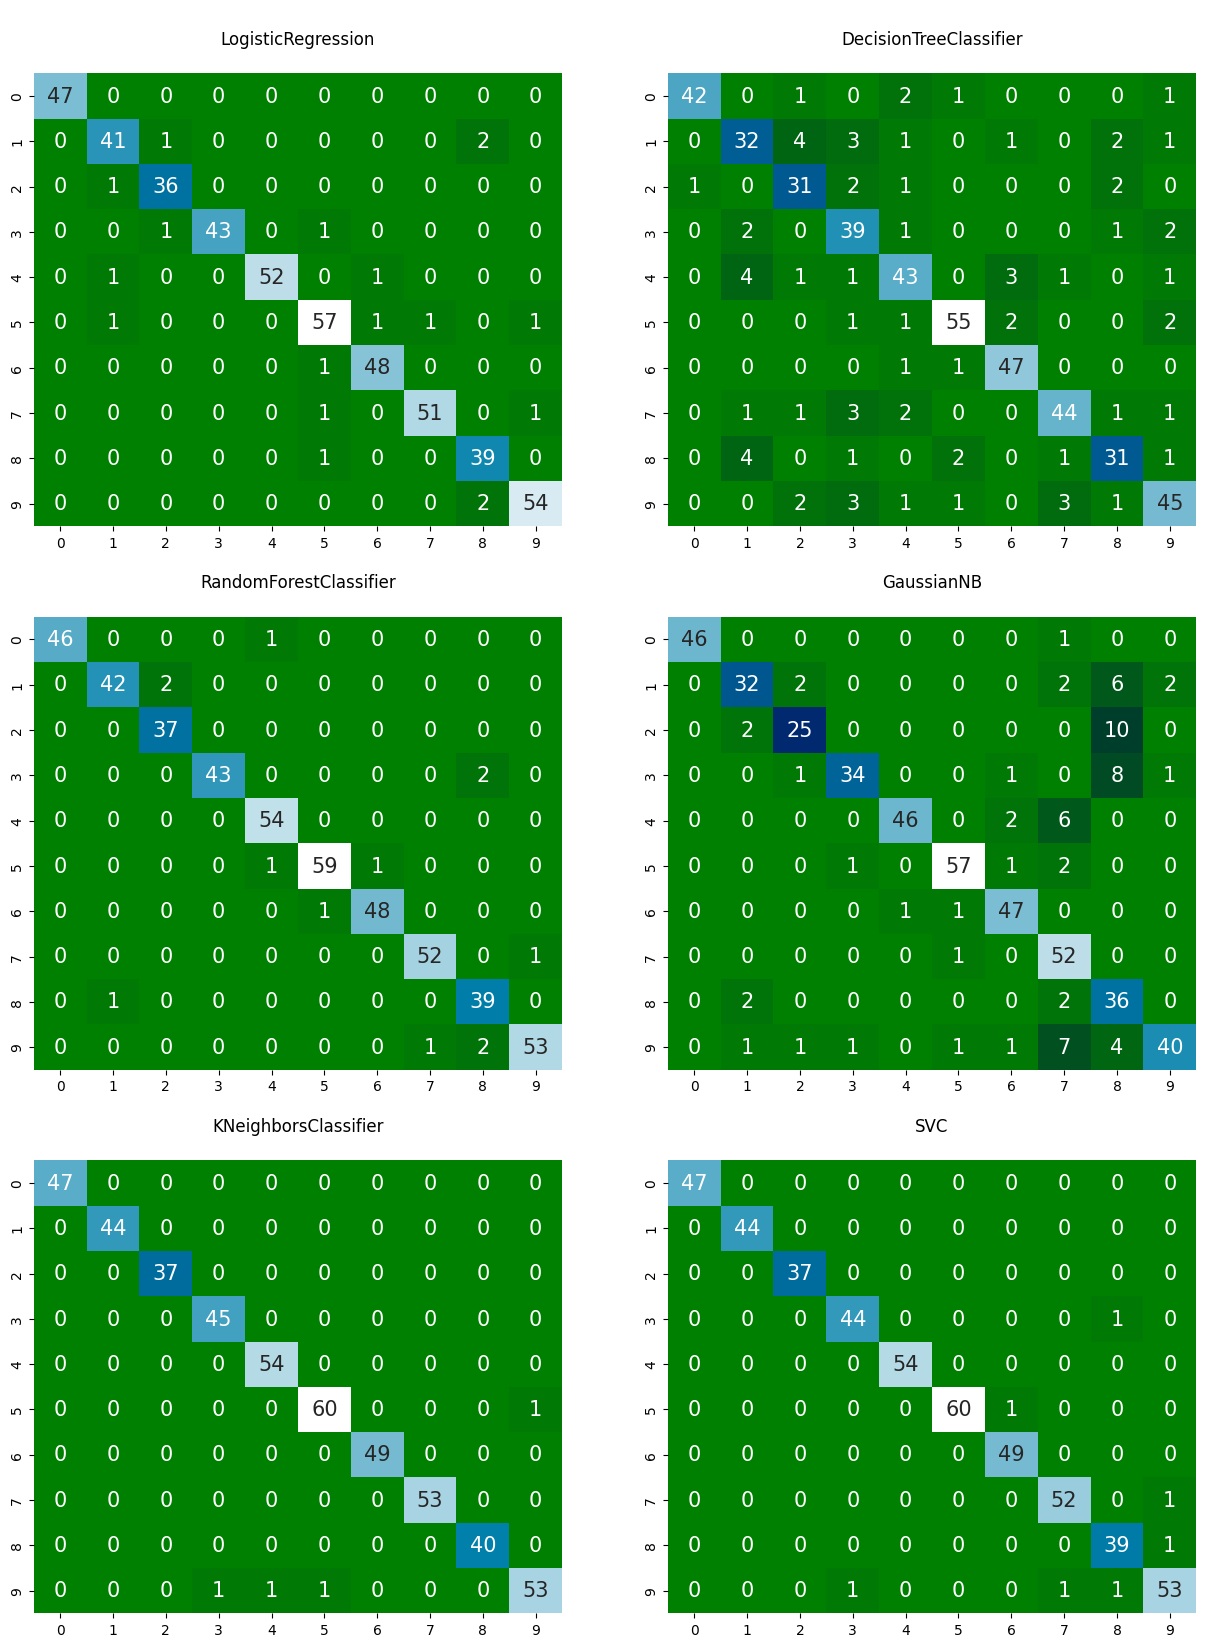

In [125]:
draw_heatmap(review_object)

##### Acurracy plot for validation set

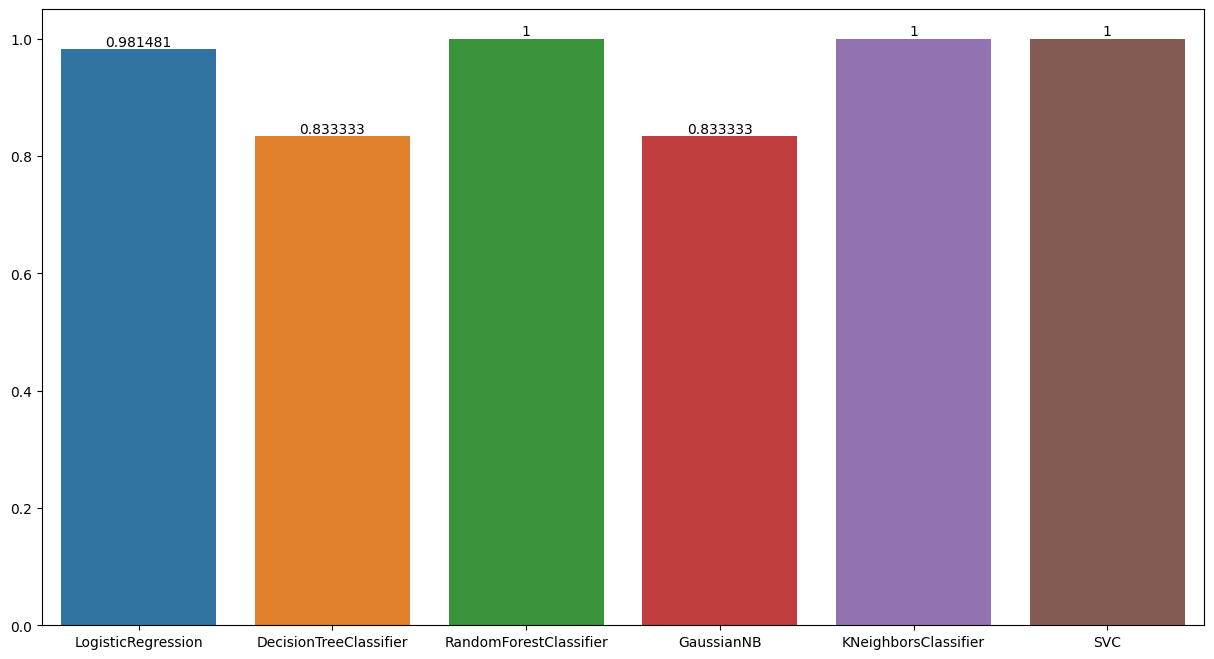

In [126]:
score_list={}
for i in model_3.trained_models:
    score_list[str(i).replace("()","")] = i.score(data_p_object_3.val_features,data_p_object_3.val_target)
fig,axes = plt.subplots(figsize=(15,8))
a = sns.barplot(x = list(score_list.keys()),y = list(score_list.values()),ax=axes)
for i in a.containers:
    a.bar_label(i)

##### Confusion Matrix for validation set

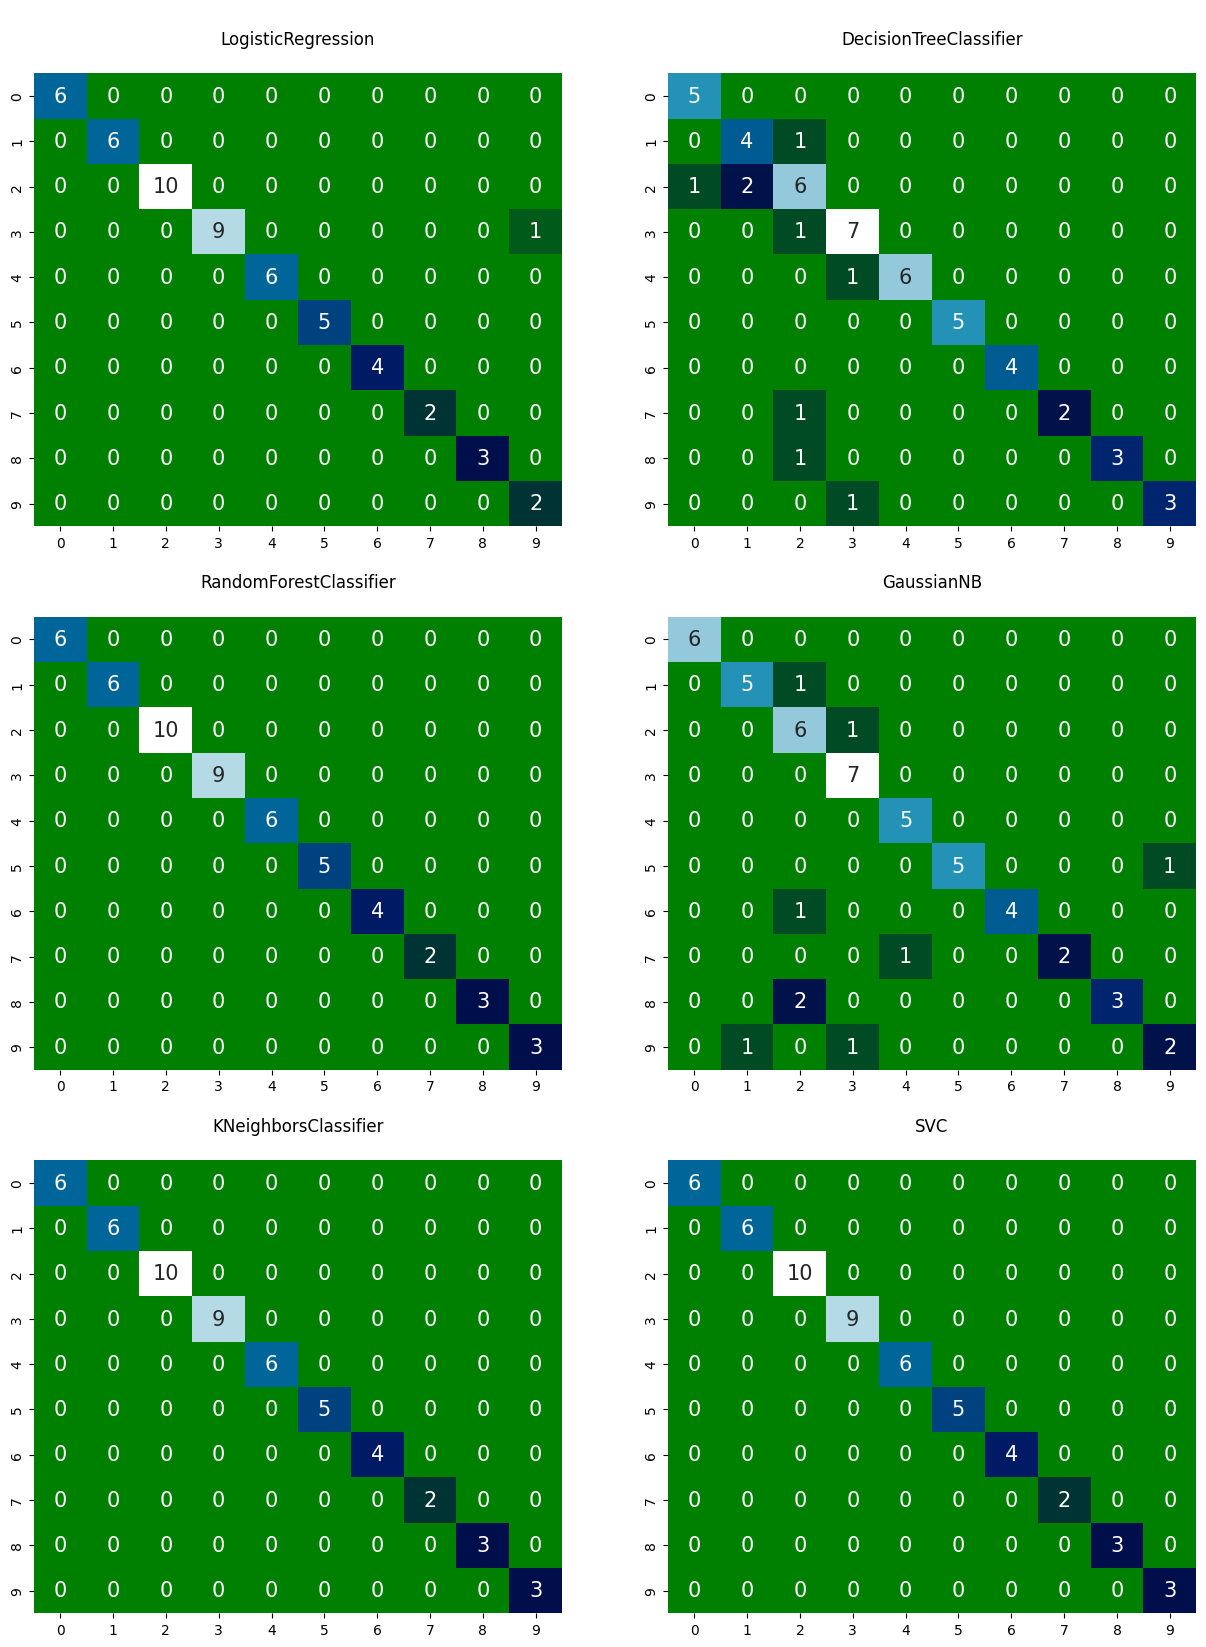

In [128]:
from sklearn.metrics import confusion_matrix
fig,axes = plt.subplots(nrows=3,ncols=2,figsize=(15,20))
confusion_matrixes ={str(model).replace("()",""):confusion_matrix(model.predict(data_p_object_3.val_features),data_p_object_3.val_target) for model in model_3.trained_models}
row = col = 0
for model in confusion_matrixes:
    if col in [2,4]:
        col=0
        row+=1
        a = sns.heatmap(confusion_matrixes[model],ax = axes[row][col],cmap='ocean',annot=True,cbar=False,annot_kws={'fontsize':15})
        a.set_title("\n"+model+"\n")
        col+=1
    else:
        a = sns.heatmap(confusion_matrixes[model],ax = axes[row][col],cmap='ocean',annot=True,cbar=False,annot_kws={'fontsize':15})
        col+=1
        a.set_title("\n"+model+"\n")
fig.show()     

In [130]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
model=DecisionTreeClassifier()
kf = KFold(10)
a = cross_val_score(model,data_p_object_3.train_features,data_p_object_3.train_target,cv=kf)
print("Acurracies :",*a)
print("The average accuracy from decision tree classifier after applying KFold is",sum(a)/len(a)*100)

Acurracies : 0.873015873015873 0.8492063492063492 0.8174603174603174 0.8333333333333334 0.8492063492063492 0.8492063492063492 0.8809523809523809 0.888 0.832 0.816
The average accuracy from decision tree classifier after applying KFold is 84.88380952380952
